In [1]:
#### Simulation of Bifidobacterium

%reset -f

In [2]:
import os
# COMETS and Gurobi paths (macOS)
os.environ["GRB_LICENSE_FILE"] = "/gpfs1/sw/rh9/pkgs/gurobi/13.0.0/linux64/licenses/gurobi.lic"

import cobra as cb
import cometspy as c
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

In [ ]:
# Load model
model_1 = cb.io.load_matlab_model('Bifidobacterium_longum_infantis_ATCC_15697.mat')

# print("Objective:", model_1.objective.expression)
# print("Objective direction:", model_1.objective.direction)

# Relax ATP maintenance reactions
# for rxn in model_1.reactions:
#     if rxn.id.upper().startswith("ATPM"):
#         rxn.lower_bound = 0.0

# Set default bounds for all exchanges: 
for rxn in model_1.exchanges:
    rxn.lower_bound = 0.0
    rxn.upper_bound = 1000.0

# Exchange list
all_exchanges_cobra = [rxn.id for rxn in model_1.exchanges]
print("Exchange reactions in model:", len(all_exchanges_cobra))

# External metabolite -> exchange reaction
met_to_ex = {met.id: rxn.id for rxn in model_1.exchanges for met in rxn.metabolites if met.compartment == 'e'}
print("External metabolites with mapped exchanges:", len(met_to_ex))

# Medium
trace_metabolites = set([      
    'h2o[e]', 'pi[e]', 'fe2[e]', 'fe3[e]', 'zn2[e]', 'so4[e]', 'cu2[e]', 'k[e]', 'mg2[e]',
    'mn2[e]', 'cd2[e]', 'cl[e]', 'ca2[e]', 'cobalt2[e]', 'ribflv[e]',
    'pnto_R[e]', 'nac[e]', 'his_L[e]', 'asn_L[e]', 'glycys[e]', 'lys_L[e]', 'ala_L[e]',
    'met_L[e]',  'leu_L[e]', 'hxan[e]', 'glyglu[e]'
])

# Limited medium
lb_media = {
    "glc_D[e]": 10.0,
    "nh4[e]":   20.0,
   # "ser_Thr[e]": 10.0,
}

# Combine medium
medium = list(trace_metabolites | set(lb_media.keys()))
print("Total metabolites allowed:", len(medium))

# FBA
with model_1 as model_t:
    # Close all exchanges
    for rxn in model_t.exchanges:
        rxn.lower_bound = 0.0
    
    # Open uptake for trace metabolites
    for met in trace_metabolites:
        ex_id = met_to_ex.get(met)
        if ex_id is not None:
            ex_rxn = model_t.reactions.get_by_id(ex_id)
            ex_rxn.lower_bound = -1000.0
        else:
            print("Warning: No exchange found:", met)
    
    # Open uptake for limited metabolites
    for met, val in lb_media.items():
        ex_id = met_to_ex.get(met)
        if ex_id is not None:
            ex_rxn = model_t.reactions.get_by_id(ex_id)
            ex_rxn.lower_bound = -val
        else:
            print("Warning: No exchange found:", met)
    
    sol = model_t.optimize()
    print("FBA growth rate with this medium:", sol.objective_value)


# COMETS model
model_1.id = "Bifido"
comets_B = c.model(model_1)

#open all exchanges
comets_B.open_exchanges()

# Set objective 
comets_B.obj_style = "MAXIMIZE_OBJECTIVE_FLUX"       #"MAX_OBJECTIVE_MIN_TOTAL"/MAXIMIZE_OBJECTIVE_FLUX (default)

# Initial population
comets_B.initial_pop = [0, 0, 0.01]

#COMETS issue: FIX
# Clean non-EX reactions from EXCH column (remove sinks)
ex_mask = comets_B.reactions["EXCH"].isin([True, "True"])
exchanges_df = comets_B.reactions[ex_mask]
for name in exchanges_df["REACTION_NAMES"]:
    name = str(name)
    if not name.startswith("EX_"):
        print("Removing non-EX exchange (sink) from EXCH:", name)
        comets_B.reactions.loc[comets_B.reactions["REACTION_NAMES"] == name, "EXCH"] = False
        comets_B.reactions.loc[comets_B.reactions["REACTION_NAMES"] == name, "EXCH_IND"] = 0
print("Total exchanges:",comets_B.reactions[comets_B.reactions["EXCH"].isin([True, "True"])].shape[0])


# Layout
layout = c.layout([comets_B])
layout.grid = [1, 1]
print("Initial media shape:", layout.media.shape)

# track of all external metabolites that have exchanges 
all_ex_mets = set(met_to_ex.keys())
for met in all_ex_mets:
    layout.set_specific_metabolite(met, 0.0)
    layout.set_specific_refresh(met, 0.0)

# Unlimited trace elements (only if mapped)
for met in trace_metabolites & all_ex_mets:
    layout.set_specific_metabolite(met, 1000.0)
    layout.set_specific_static(met, 1000)

# Limited nutrients 
for met in lb_media:
    if met in all_ex_mets:
        layout.set_specific_metabolite(met, lb_media[met])
        layout.set_specific_refresh(met, 0.0)

print("Number of media compounds in layout:", len(layout.media))
print("Media metabolites:", set(layout.media["metabolite"].values))

# Parameters
vol = 0.1     
params = c.params()

# Adjust Params
params.set_param("spaceWidth", vol**(1/3))
params.set_param("defaultVmax", 10.0)    
params.set_param("defaultKm", 0.01)   

# Set timestep
t_step = 0.1        #hours
t_total = 250       #cycles (discrete simulation steps)

params.set_param("timeStep", t_step)            # hours
params.set_param("maxSpaceBiomass", 10)        #grams 
params.set_param("minSpaceBiomass", 1e-11)      #grams 
params.set_param("maxCycles", t_total)
params.set_param("writeMediaLog", True)
params.set_param("MediaLogRate", 1)
params.set_param("writeFluxLog", True)
params.set_param("FluxLogRate", 1)
params.set_param("writeBiomassLog", True)
params.set_param("BiomassLogRate", 1)
params.set_param("exchangestyle", "Monod Style")


sim = c.comets(layout, params)
sim.run()

No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e


Exchange reactions in model: 163
External metabolites with mapped exchanges: 162
Total metabolites allowed: 28
FBA growth rate with this medium: 0.13353637458967674
Removing non-EX exchange (sink) from EXCH: sink_PGPm1[c]
Removing non-EX exchange (sink) from EXCH: sink_dmbzid
Removing non-EX exchange (sink) from EXCH: sink_thissh[c]
Total exchanges: 163
Initial media shape: (163, 6)
Number of media compounds in layout: 163
Media metabolites: {'core3[e]', 'f1a[e]', 'biomass[c]', 'arab_L[e]', 'cholate[e]', 'HC02192[e]', 'xylottr[e]', 'pro_L[e]', 'stys[e]', 'HC02193[e]', 'fol[e]', 'mantr[e]', 'M01989[e]', 'acnam[e]', 'acgam[e]', 'dchac[e]', 'mnl[e]', 'fru[e]', 'glypro[e]', 'Ser_Thr[e]', 'malthx[e]', '4abz[e]', 'metala[e]', 'salcn[e]', 'taur[e]', 'alagly[e]', 'gncore2[e]', 'dsT_antigen[e]', 'fuc_L[e]', 'xan[e]', 'alaglu[e]', 'succ[e]', 'oxa[e]', 'his_L[e]', 'ribflv[e]', 'sT_antigen[e]', 'o2[e]', 'glyglu[e]', 'ppi[e]', 'tchola[e]', 'alahis[e]', 'mqn8[e]', 'alaasp[e]', 'alaleu[e]', 'tre[e]',

In [4]:
df_ex = sim.get_species_exchange_fluxes("Bifido", threshold=0.0).copy()

# Find exchange columns
ex_cols = [c for c in df_ex.columns if isinstance(c, str) and c.startswith("EX_")]
# Pick a valid time index
t =0   #min(1, len(df_ex) - 1)
#Extract row and find uptake (negative flux)
row = pd.to_numeric(df_ex.loc[t, ex_cols], errors="coerce")
uptake = row[row < -1e-9].sort_values()
print(f"\nUptake fluxes at row {t} (most negative = strongest uptake):\n")
print(uptake.head(30))


Uptake fluxes at row 0 (most negative = strongest uptake):

EX_glc_D(e)     -9.999000
EX_glyglu(e)    -0.513156
EX_nh4(e)       -0.344866
EX_pi(e)        -0.197623
EX_hxan(e)      -0.058983
EX_leu_L(e)     -0.058571
EX_glycys(e)    -0.034949
EX_asn_L(e)     -0.031335
EX_his_L(e)     -0.012367
EX_nac(e)       -0.002085
EX_pnto_R(e)    -0.002085
EX_ribflv(e)    -0.002085
EX_fe3(e)       -0.001043
EX_fe2(e)       -0.001043
EX_cu2(e)       -0.001043
EX_cl(e)        -0.001043
EX_mn2(e)       -0.001043
EX_mg2(e)       -0.001043
EX_k(e)         -0.001043
EX_ca2(e)       -0.001043
EX_cobalt2(e)   -0.001043
EX_so4(e)       -0.001043
EX_zn2(e)       -0.001043
Name: 0, dtype: float64


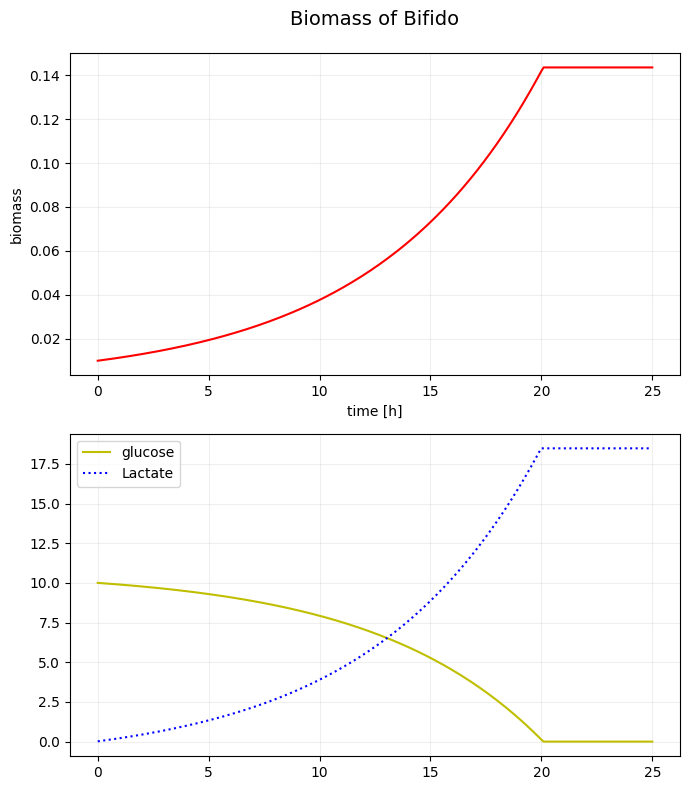

In [5]:
# Plotting
[fig,axs]=plt.subplots(2,1,figsize=[7,8])
t_array = np.arange(0,(t_total+t_step/2)*t_step,t_step)

# Plot Biomass
biomass = np.array(sim.total_biomass.Bifido)
axs[0].plot(t_array,biomass,'r-')
axs[0].set_xlabel('time [h]')
axs[0].set_ylabel('biomass')
axs[0].set_title("Biomass of Bifido", fontsize=14, pad=20)
axs[0].grid(alpha=0.2)

# Plot metabolites
md = sim.media
m = 'glc_D[e]'
met_m = np.zeros(len(t_array))
for i in range(len(md.loc[md['metabolite']==m].conc_mmol.values)):
    met_m[i] = md.loc[md['metabolite']==m].conc_mmol.values[i]
axs[1].plot(t_array,met_m,'y')

m = 'lac_L[e]' 
met_data = md.loc[md['metabolite']==m, 'conc_mmol'].values
t_data = t_array[:len(met_data)]
axs[1].plot(t_data, met_data, ':b')
axs[1].legend(['glucose', 'Lactate'])
axs[1].grid(alpha=0.2)
    
fig.tight_layout()

Selected metabolites from medium: 31
Metabolites: ['4abut[e]', 'ac[e]', 'asn_L[e]', 'ca2[e]', 'cd2[e]', 'cl[e]', 'co2[e]', 'cobalt2[e]', 'cu2[e]', 'fe2[e]', 'fe3[e]', 'glc_D[e]', 'glycys[e]', 'glyglu[e]', 'h2o[e]', 'h[e]', 'his_L[e]', 'hxan[e]', 'k[e]', 'lac_L[e]', 'leu_L[e]', 'met_L[e]', 'mg2[e]', 'mn2[e]', 'nac[e]', 'nh4[e]', 'pi[e]', 'pnto_R[e]', 'ribflv[e]', 'so4[e]', 'zn2[e]']


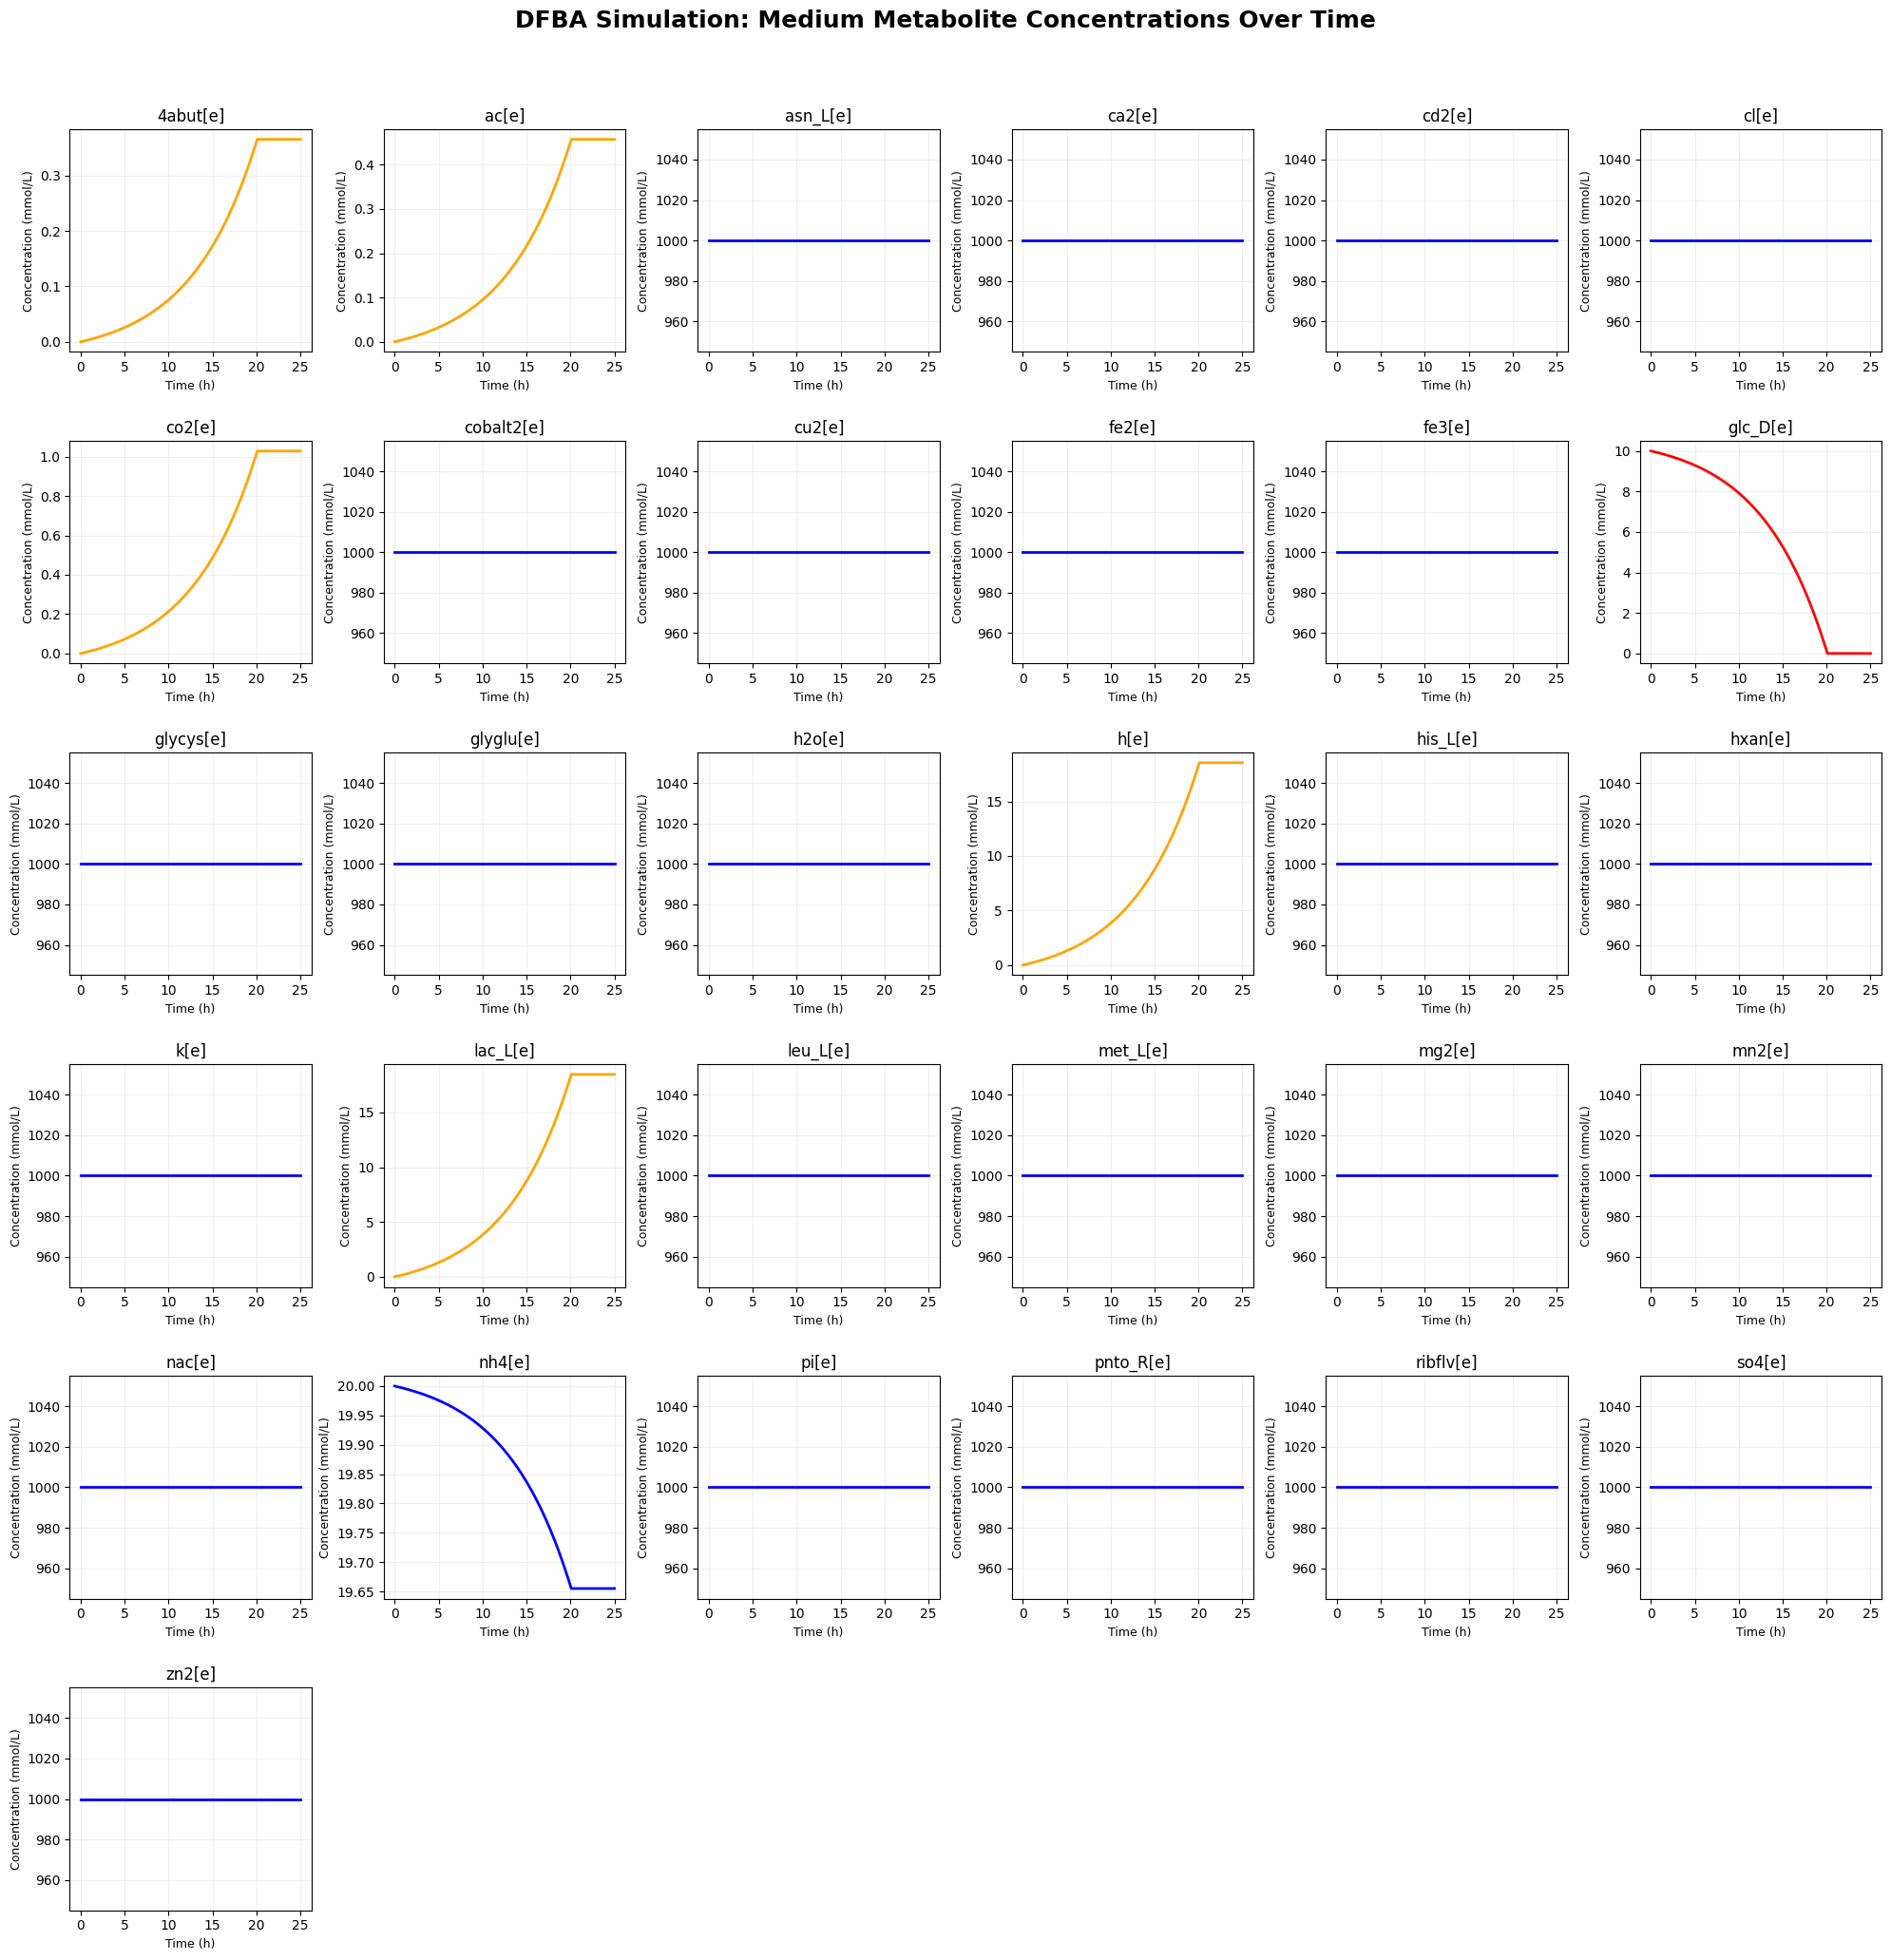

In [6]:
# Metabolite concentrations
media_piv = sim.media.pivot(index='cycle', columns='metabolite', values='conc_mmol')
media_piv.fillna(0, inplace=True)

conc_df = media_piv.copy()

#all metabolites in the simulation
available_mets = set(conc_df.columns)

# Find intersection
selected_mets = list(available_mets)
#selected_mets = list(available_mets & set(medium))

# Sort for consistent ordering
selected_mets = sorted(selected_mets)

# Remove biomass if it somehow got included
selected_mets = [m for m in selected_mets if 'biomass' not in m.lower()]

print(f"Selected metabolites from medium: {len(selected_mets)}")
print(f"Metabolites: {selected_mets}")

# Create subplots
num_mets = len(selected_mets)
cols = 6
rows = math.ceil(num_mets / cols)
fig2 = plt.figure(figsize=(20, 3.5 * rows))

fig2.suptitle('DFBA Simulation: Medium Metabolite Concentrations Over Time', 
              fontsize=18, 
              fontweight='bold', 
              y=0.98)

time_conc = conc_df.index * params.all_params['timeStep']

for i, met in enumerate(selected_mets):
    ax = fig2.add_subplot(rows, cols, i+1)
    
    conc = conc_df[met]
    
    # Color coding: red if consumed (starts > 0, ends at 0), blue otherwise
    if len(conc) > 0 and conc.iloc[0] > 0 and conc.iloc[-1] == 0:
        line_color = 'red'
    elif len(conc) > 0 and conc.iloc[0] == 0:
        line_color = 'orange'
    elif len(conc) > 0 and conc.max() > conc.min():
        line_color = 'blue'
    else:
        line_color = 'blue'
    
    ax.plot(time_conc, conc, color=line_color, linewidth=2)
    ax.set_xlabel('Time (h)', fontsize=9)
    ax.set_ylabel('Concentration (mmol/L)', fontsize=9)
    ax.set_title(met, fontsize=12)
    ax.grid(alpha=0.2)

plt.tight_layout(rect=[0, 0, 1, 0.96]) 
fig2.subplots_adjust(top=0.92, hspace=0.4, wspace=0.3)  
plt.show()

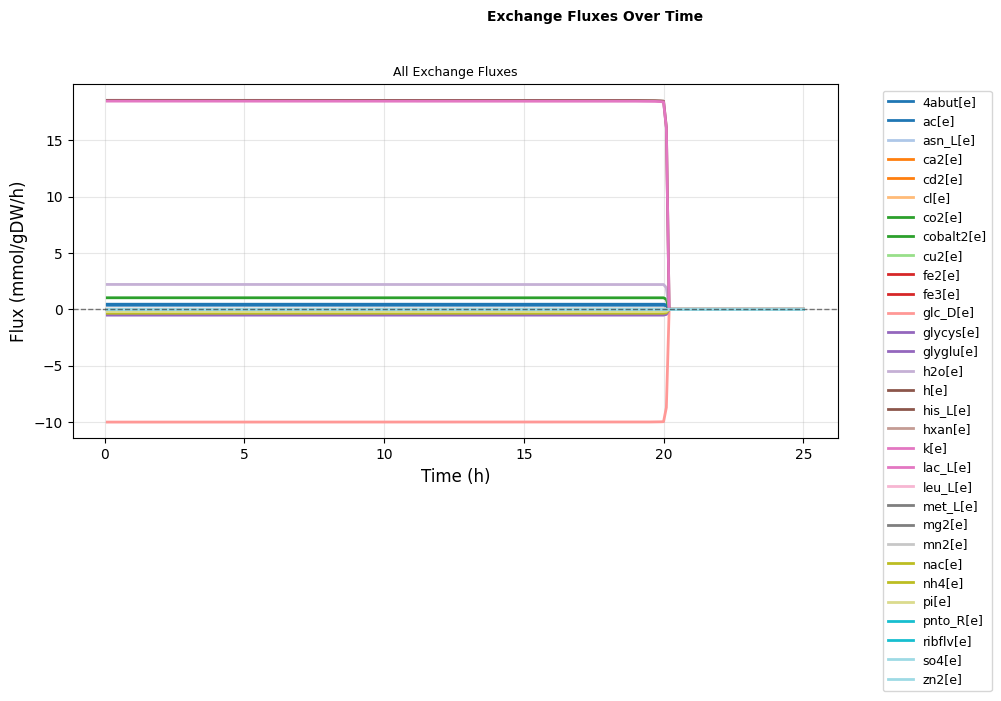

In [9]:
# Flux plot 
selected_flux_mets = [m for m in selected_mets if m != 'Biomass' and m in media_piv.columns]

fig3, ax = plt.subplots(figsize=(12, 6))

fig3.suptitle('Exchange Fluxes Over Time', fontsize=10, fontweight='bold', y=0.98)

time_flux = sim.fluxes.iloc[:, 0] * params.all_params['timeStep']

# Use a colormap for different colors
colors = plt.cm.tab20(np.linspace(0, 1, len(selected_flux_mets)))

for i, met in enumerate(sorted(selected_flux_mets)):
    met_reaction_format = met.replace('[e]', '(e)')
    rxn_id = 'EX_' + met_reaction_format
     
    rxn_idx = comets_B.reactions[comets_B.reactions['REACTION_NAMES'] == rxn_id].index[0]
    col = 4 + rxn_idx
    flux = sim.fluxes.iloc[:, col]
    ax.plot(time_flux, flux, color=colors[i], linewidth=2, label=met)

ax.axhline(y=0, color='black', linestyle='--', linewidth=1, alpha=0.5)
ax.set_xlabel('Time (h)', fontsize=12)
ax.set_ylabel('Flux (mmol/gDW/h)', fontsize=12)
ax.set_title('All Exchange Fluxes', fontsize=9)
ax.grid(alpha=0.3)
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=9, ncol=1)

plt.tight_layout(rect=[0, 0, 0.85, 0.96])
plt.show()

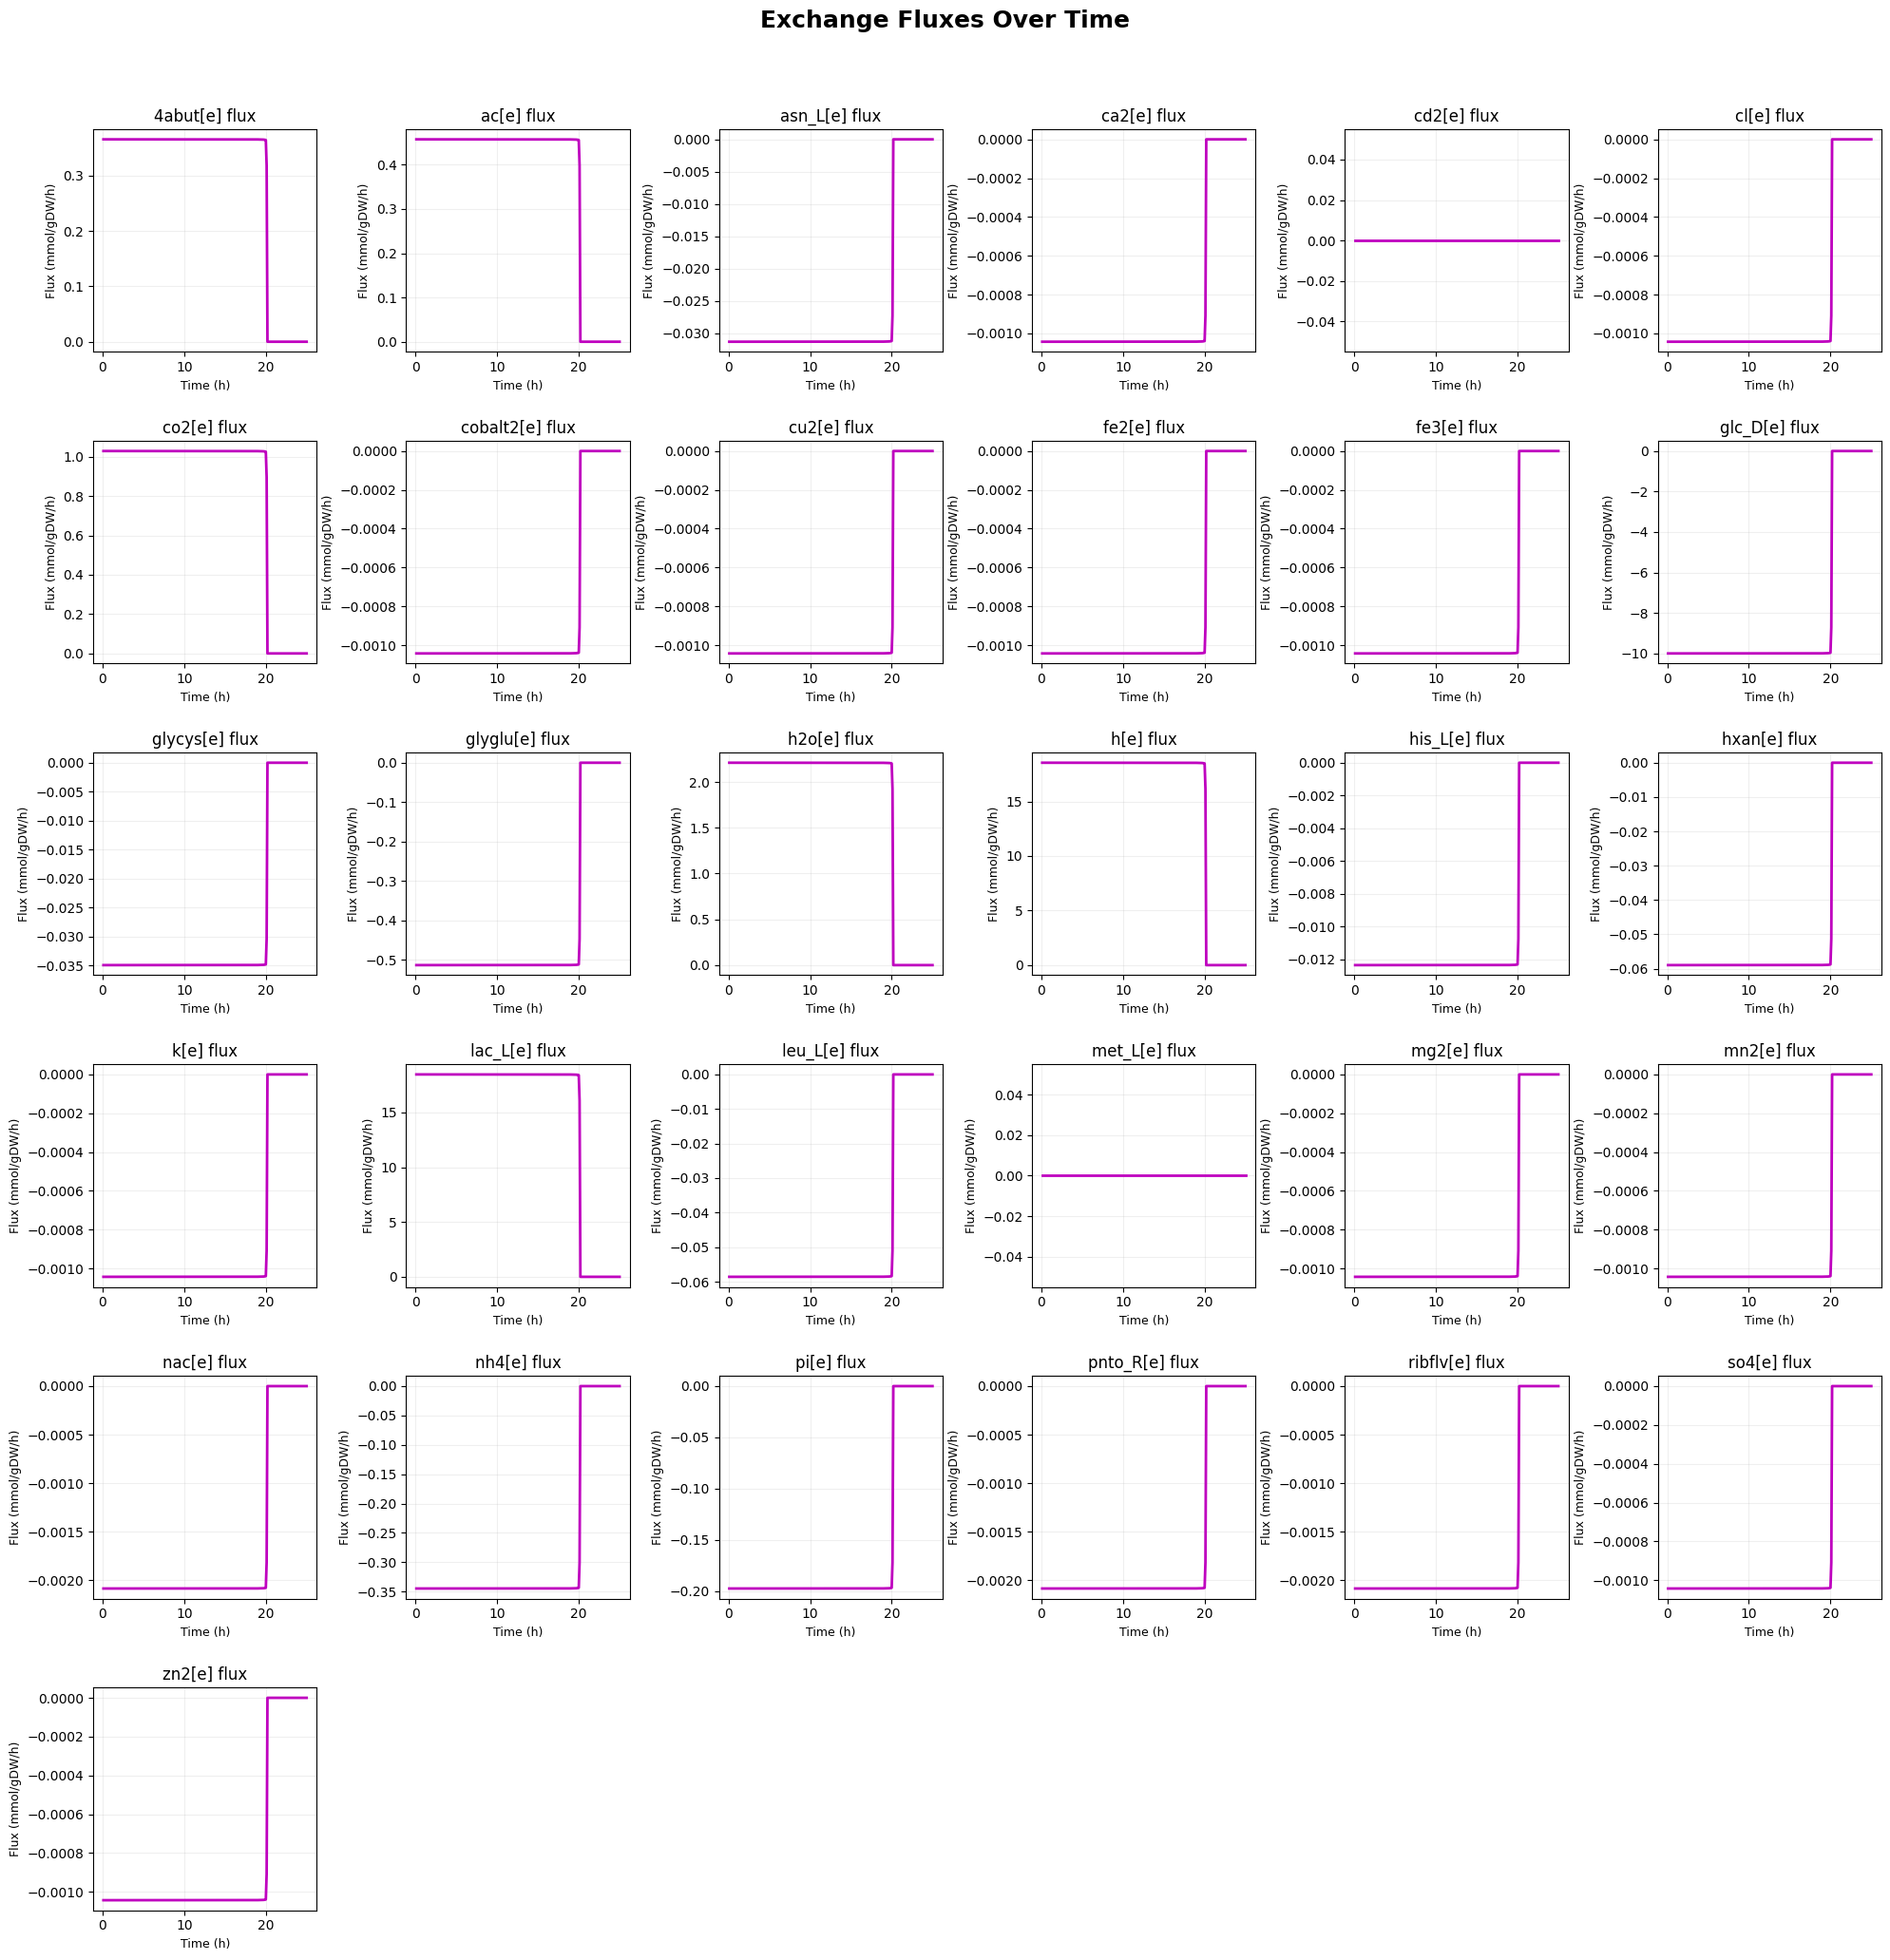

In [10]:
# Flux plot
selected_flux_mets = [m for m in selected_mets if m != 'Biomass' and m in media_piv.columns]
num_flux = len(selected_flux_mets)
rows_flux = math.ceil(num_flux / cols)
fig3 = plt.figure(figsize=(20, 3.5 * rows_flux))

fig3.suptitle('Exchange Fluxes Over Time', fontsize=18, fontweight='bold', y=0.98)
for i, met in enumerate(sorted(selected_flux_mets)):
    met_reaction_format = met.replace('[e]', '(e)')
    rxn_id = 'EX_' + met_reaction_format
    
    rxn_idx = comets_B.reactions[comets_B.reactions['REACTION_NAMES'] == rxn_id].index[0]
    col = 4 + rxn_idx
    flux = sim.fluxes.iloc[:, col]
    ax = fig3.add_subplot(rows_flux, cols, i+1)
    ax.plot(time_flux, flux, color='m', linewidth=2)
    ax.set_title(met + ' flux', fontsize=12)
    ax.set_xlabel('Time (h)', fontsize=9)
    ax.set_ylabel('Flux (mmol/gDW/h)', fontsize=9)
    ax.grid(alpha=0.2)


plt.tight_layout(rect=[0, 0, 1, 0.96])
fig3.subplots_adjust(top=0.92, hspace=0.4, wspace=0.4)

plt.show()

In [1]:
 ### Simulation of Eubacterium

%reset -f

import os
# COMETS and Gurobi paths (macOS)
os.environ["GRB_LICENSE_FILE"] = "/gpfs1/sw/rh9/pkgs/gurobi/13.0.0/linux64/licenses/gurobi.lic"

import cobra as cb
import cometspy as c
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

In [2]:
# Load model
model_1 = cb.io.load_matlab_model('Eubacterium_hallii_DSM_3353.mat')

# Relax ATP maintenance reactions
# for rxn in model_1.reactions:
#     if rxn.id.upper().startswith("ATPM"):
#         rxn.lower_bound = 0.0

# Set default bounds for all exchanges: 
for rxn in model_1.exchanges:
    rxn.lower_bound = 0.0
    rxn.upper_bound = 1000.0

# Exchange list
all_exchanges_cobra = [rxn.id for rxn in model_1.exchanges]
print("Exchange reactions in model:", len(all_exchanges_cobra))

# External metabolite -> exchange reaction 
met_to_ex = {met.id: rxn.id for rxn in model_1.exchanges for met in rxn.metabolites if met.compartment == 'e'}
print("External metabolites with mapped exchanges:", len(met_to_ex))

# Medium
trace_metabolites = set([      
    'h2o[e]', 'pi[e]', 'fe2[e]', 'fe3[e]', 'zn2[e]', 'so4[e]', 'cu2[e]', 'k[e]', 'mg2[e]',
    'mn2[e]', 'cd2[e]', 'cl[e]', 'ca2[e]', 'cobalt2[e]', 'ribflv[e]',
    'pnto_R[e]', 'nac[e]', 'his_L[e]', 'asn_L[e]', 'glycys[e]', 'lys_L[e]', 'ala_L[e]',
    'met_L[e]',  'leu_L[e]', 'hxan[e]', 'glyglu[e]'
])

# Limited medium
lb_media = {
    "glc_D[e]": 10.0,
    "nh4[e]": 20.0,
    #"ser_L[e]": 10.0,
}

# lb_media = {
#     "lac_L[e]": 20.0,
#     "nh4[e]": 20.0,
#     #"ser_L[e]": 1.0,
# }

# Combine medium
medium = list(trace_metabolites | set(lb_media.keys()))
print("Total metabolites allowed:", len(medium))

# FBA
with model_1 as model_t:
    # Close all exchanges
    for rxn in model_t.exchanges:
        rxn.lower_bound = 0.0
    
    # Open uptake for trace metabolites
    for met in trace_metabolites:
        ex_id = met_to_ex.get(met)
        if ex_id is not None:
            ex_rxn = model_t.reactions.get_by_id(ex_id)
            ex_rxn.lower_bound = -1000.0
        else:
            print("Warning: No exchange found :", met)
    
    # Open uptake for limited metabolites
    for met, val in lb_media.items():
        ex_id = met_to_ex.get(met)
        if ex_id is not None:
            ex_rxn = model_t.reactions.get_by_id(ex_id)
            ex_rxn.lower_bound = -val
        else:
            print("Warning: No exchange found :", met)
    
    sol = model_t.optimize()
    print("FBA growth rate with this medium:", sol.objective_value)

No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e


Exchange reactions in model: 120
External metabolites with mapped exchanges: 119
Total metabolites allowed: 28
FBA growth rate with this medium: 0.4147595691023777


In [3]:
# COMETS model
model_1.id = "Eubacterium"
comets_B = c.model(model_1)

# Set objective 
comets_B.obj_style = "MAXIMIZE_OBJECTIVE_FLUX"  # "MAXIMIZE_OBJECTIVE_FLUX"/ "MAX_OBJECTIVE_MIN_TOTAL"
comets_B.open_exchanges()

# Initial population
comets_B.initial_pop = [0, 0, 0.01]

#COMETS issue: FIX
# Clean non-EX reactions from EXCH column (remove sinks)
ex_mask = comets_B.reactions["EXCH"].isin([True, "True"])
exchanges_df = comets_B.reactions[ex_mask]
for name in exchanges_df["REACTION_NAMES"]:
    name = str(name)
    if not name.startswith("EX_"):
        print("Removing non-EX exchange (sink) from EXCH:", name)
        comets_B.reactions.loc[comets_B.reactions["REACTION_NAMES"] == name, "EXCH"] = False
        comets_B.reactions.loc[comets_B.reactions["REACTION_NAMES"] == name, "EXCH_IND"] = 0
print("Total exchanges(COMETS):", comets_B.reactions[comets_B.reactions["EXCH"].isin([True, "True"])].shape[0])

# Layout
layout = c.layout([comets_B])
layout.grid = [1, 1]
print("Initial media shape:", layout.media.shape)

# track of all external metabolites that have exchanges 
all_ex_mets = set(met_to_ex.keys())
for met in all_ex_mets:
    layout.set_specific_metabolite(met, 0.0)
    layout.set_specific_refresh(met, 0.0)

# Unlimited trace elements (only if mapped)
for met in trace_metabolites:
    layout.set_specific_metabolite(met, 100.0)
    layout.set_specific_static(met, 1000)

# Limited nutrients 
for met in lb_media:
    if met in all_ex_mets:
        layout.set_specific_metabolite(met, lb_media[met])
        layout.set_specific_refresh(met, 0.0)

print("Number of media compounds in layout:", len(layout.media))
print("Media metabolites:", set(layout.media["metabolite"].values))

# Parameters
vol = 0.1
params = c.params()

# Adjust Params
params.set_param("spaceWidth", vol**(1/3))
params.set_param("defaultVmax", 10.)
params.set_param("defaultKm", 0.01)

# Set timestep
t_step = 0.1
t_total = 250
params.set_param("timeStep", t_step)  # hours
params.set_param("maxSpaceBiomass", 10.)
params.set_param("minSpaceBiomass", 1e-11)
params.set_param("maxCycles", t_total)
params.set_param("writeMediaLog", True)
params.set_param("MediaLogRate", 1)
params.set_param("writeFluxLog", True)
params.set_param("FluxLogRate", 1)
params.set_param("writeBiomassLog", True)
params.set_param("BiomassLogRate", 1)
params.set_param("exchangestyle", "Monod Style")

sim = c.comets(layout, params)
sim.run()

Removing non-EX exchange (sink) from EXCH: sink_PGPm1[c]
Removing non-EX exchange (sink) from EXCH: sink_dmbzid
Removing non-EX exchange (sink) from EXCH: sink_s
Removing non-EX exchange (sink) from EXCH: sink_thissh[c]
Total exchanges(COMETS): 120
Initial media shape: (120, 6)
Number of media compounds in layout: 120
Media metabolites: {'fe2[e]', 'ac[e]', 'metsox_S_L[e]', 'ala_L[e]', 'kestopt[e]', 'h2o[e]', 'cholate[e]', 'alaleu[e]', 'btn[e]', 'cgly[e]', 'glyasn[e]', 'spmd[e]', 'pcresol[e]', '4ahmmp[e]', 'met_D[e]', 'hg2[e]', '7a_czp[e]', 'nchlphncl[e]', 'co2[e]', 'glyleu[e]', 'mnl[e]', 'nmn[e]', 'drib[e]', 'man[e]', 'kestottr[e]', 'his_L[e]', 'pnto_R[e]', 'for[e]', 'glyphe[e]', 'ile_L[e]', 'alagly[e]', 'fru[e]', 'cl[e]', 'glygln[e]', 'gchola[e]', 'mn2[e]', 'pro_L[e]', 'na1[e]', 'xyl_D[e]', 'leu_L[e]', 'dgchol[e]', 'rbflvrd[e]', 'tchola[e]', 'glyasp[e]', 'melib[e]', 'fol[e]', 'mobd[e]', 'pydx[e]', 'glytyr[e]', 'glyc[e]', 'h2[e]', 'o2[e]', 'lys_L[e]', 'inulin[e]', 'trp_L[e]', 'mg2[e]',

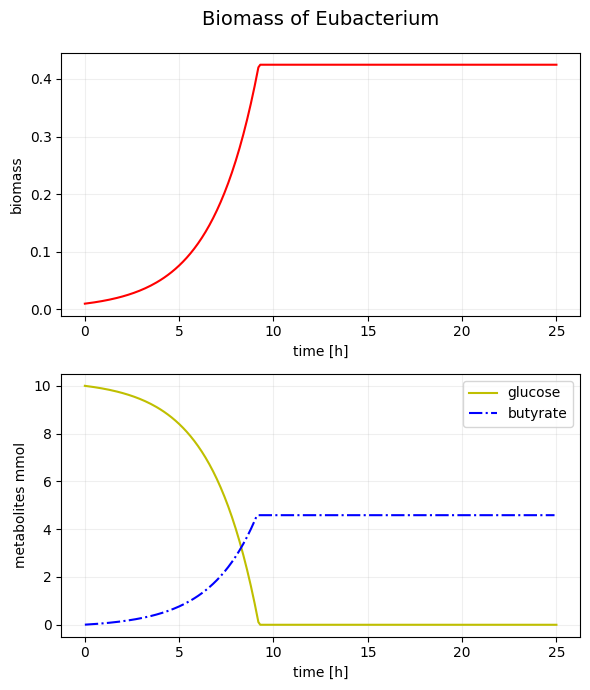

In [4]:
# Plotting
[fig,axs]=plt.subplots(2,1,figsize=[6,7])
t_array = np.arange(0,(t_total+t_step/2)*t_step,t_step)

# Plot Biomass
biomass = np.array(sim.total_biomass.Eubacterium)
axs[0].plot(t_array,biomass,'r-')
axs[0].set_xlabel('time [h]')
axs[0].set_ylabel('biomass')
axs[0].set_title("Biomass of Eubacterium", fontsize=14, pad=20)
axs[0].grid(alpha=0.2)

# Plot metabolites
md = sim.media
m = 'glc_D[e]'
met_m = np.zeros(len(t_array))
for i in range(len(md.loc[md['metabolite']==m].conc_mmol.values)):
    met_m[i] = md.loc[md['metabolite']==m].conc_mmol.values[i]
axs[1].plot(t_array,met_m,'y')

m = 'but[e]'
met_data = md.loc[md['metabolite']==m, 'conc_mmol'].values
t_data = t_array[:len(met_data)]
axs[1].plot(t_data, met_data, '-.b')
axs[1].set_ylabel('metabolites mmol')
axs[1].set_xlabel('time [h]')
axs[1].legend(['glucose', 'butyrate'])
axs[1].grid(alpha=0.2)

fig.tight_layout()

Selected metabolites from medium: 32
Metabolites: ['ac[e]', 'ala_L[e]', 'asn_L[e]', 'but[e]', 'ca2[e]', 'cd2[e]', 'cl[e]', 'co2[e]', 'cobalt2[e]', 'cu2[e]', 'fe2[e]', 'fe3[e]', 'glc_D[e]', 'glycys[e]', 'glyglu[e]', 'h2[e]', 'h2o[e]', 'his_L[e]', 'hxan[e]', 'k[e]', 'leu_L[e]', 'lys_L[e]', 'met_L[e]', 'mg2[e]', 'mn2[e]', 'nac[e]', 'nh4[e]', 'pi[e]', 'pnto_R[e]', 'ribflv[e]', 'so4[e]', 'zn2[e]']


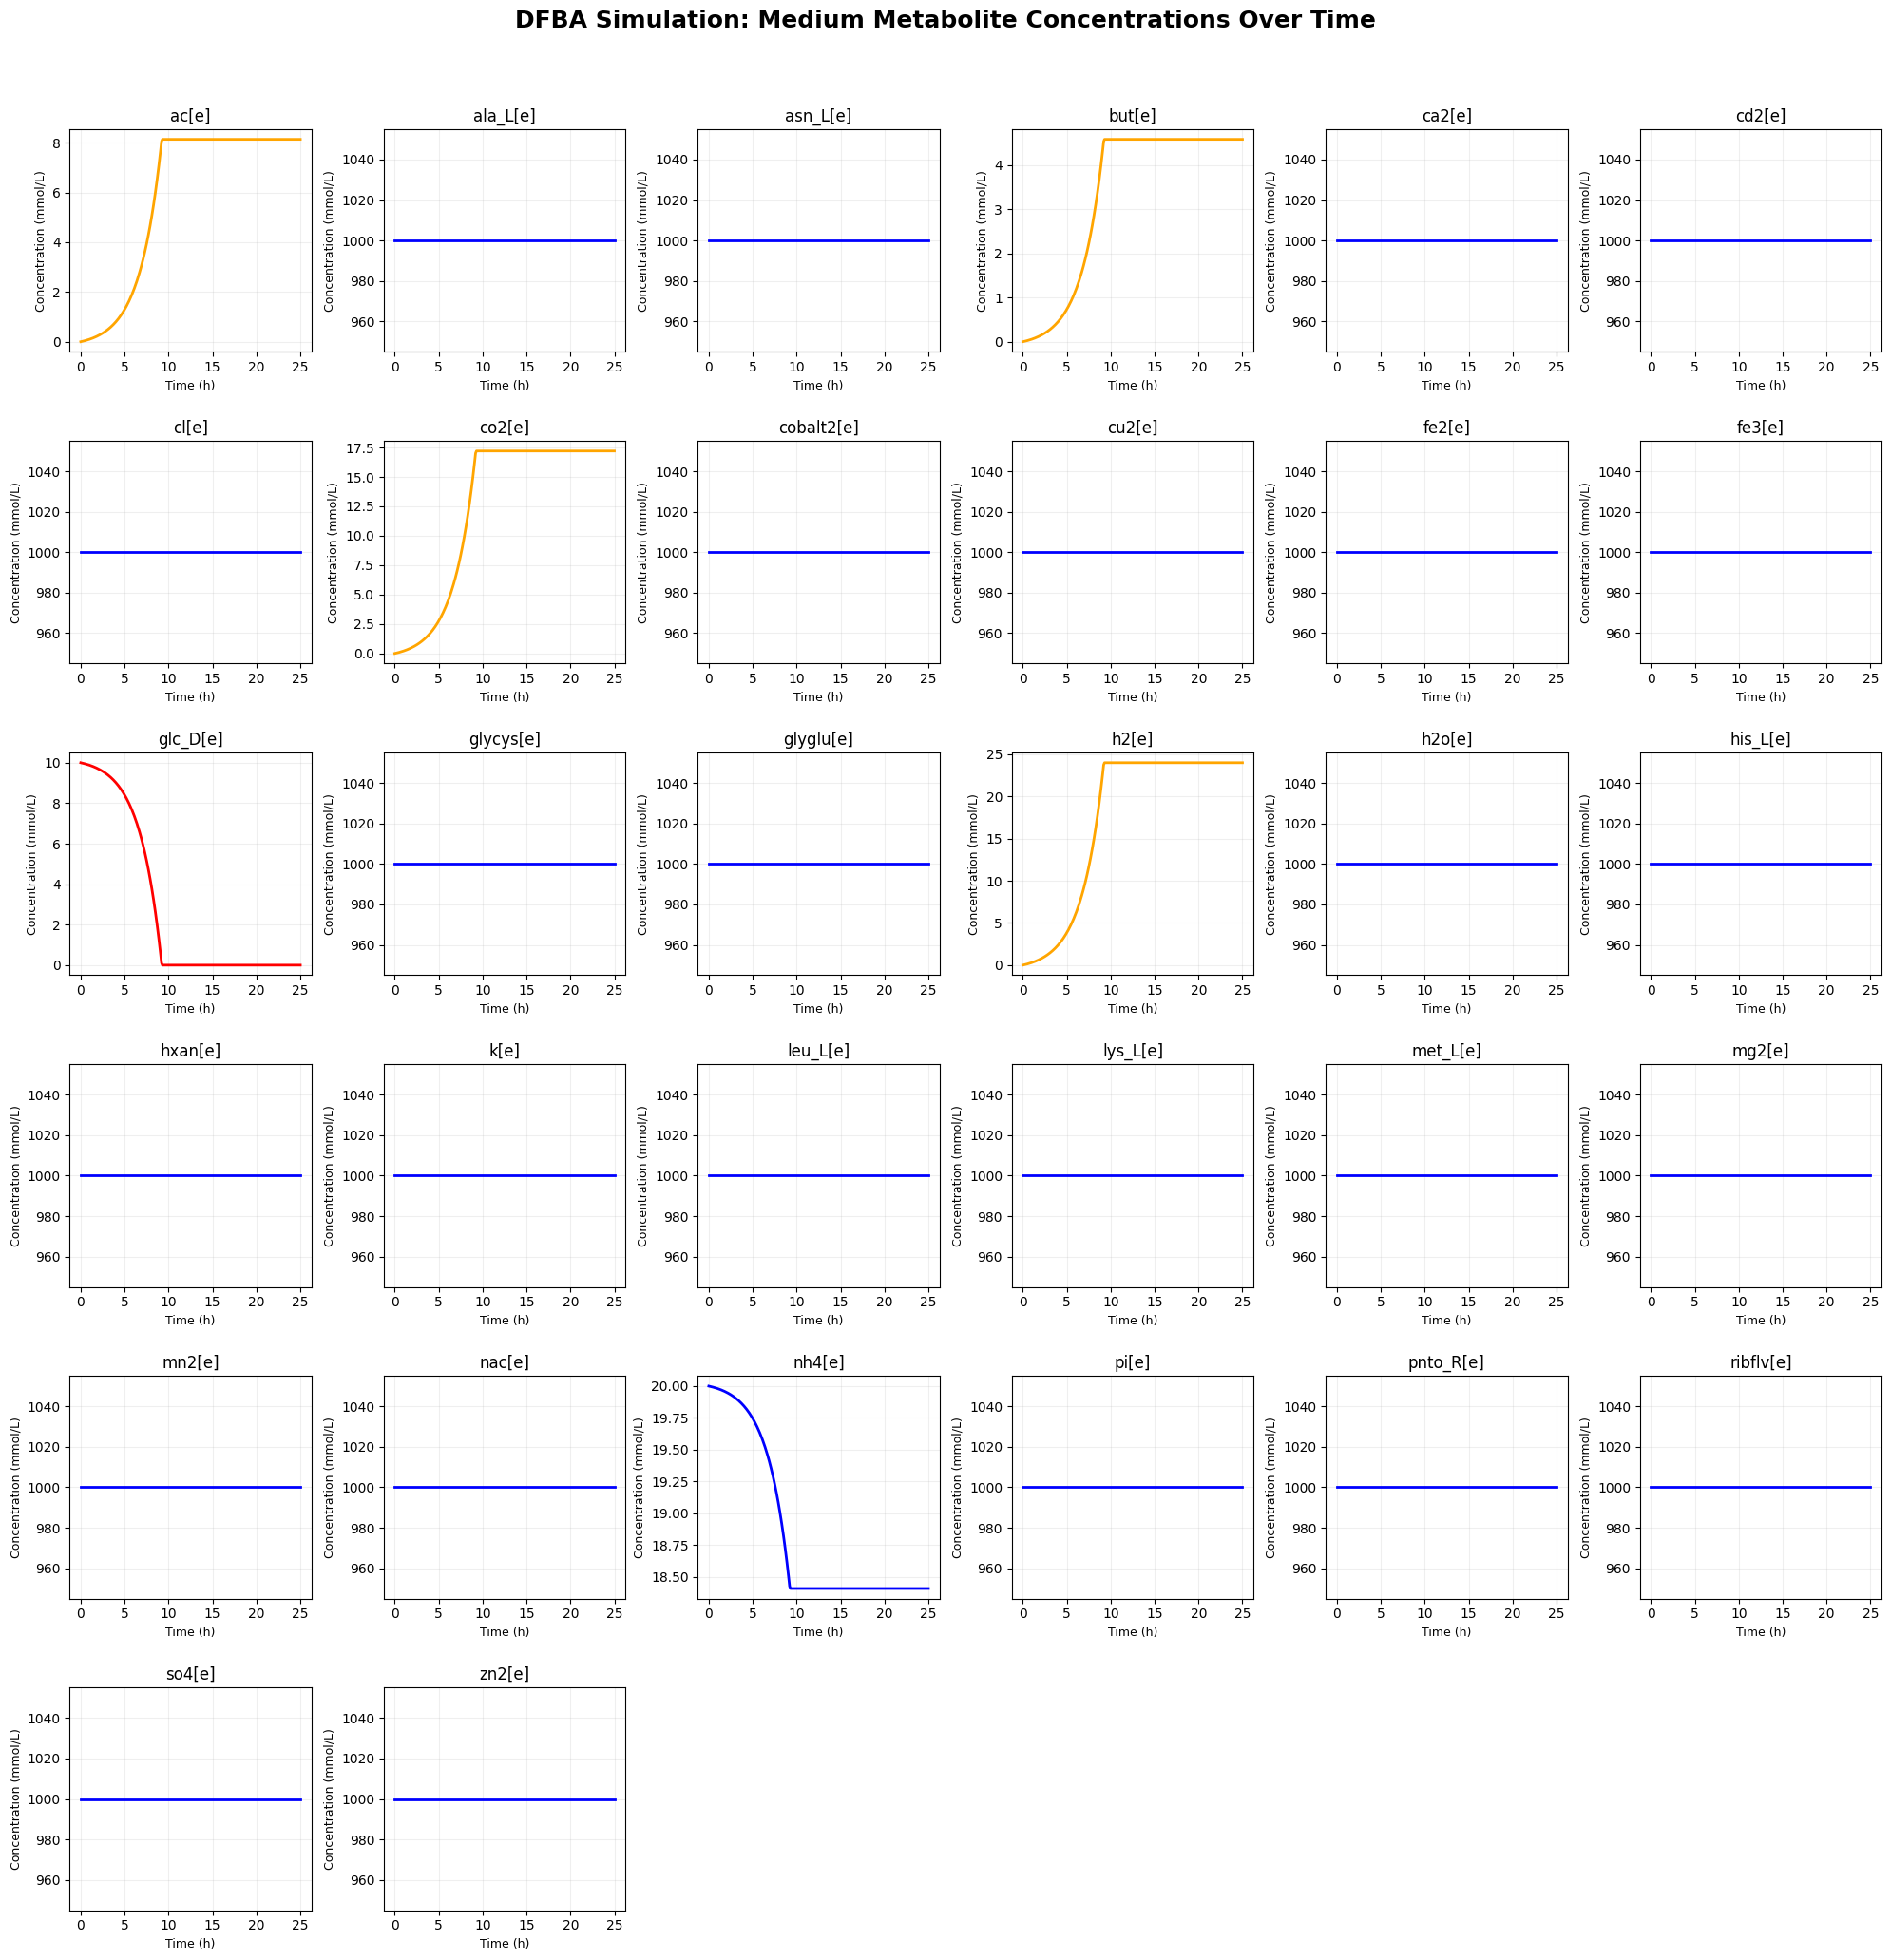

In [5]:
# Metabolite concentrations
media_piv = sim.media.pivot(index='cycle', columns='metabolite', values='conc_mmol')
media_piv.fillna(0, inplace=True)

conc_df = media_piv.copy()

#all metabolites in the simulation
available_mets = set(conc_df.columns)

# Find intersection
selected_mets = list(available_mets)
#selected_mets = list(available_mets & set(medium))

# Sort for consistent ordering
selected_mets = sorted(selected_mets)

# Remove biomass 
selected_mets = [m for m in selected_mets if 'biomass' not in m.lower()]

print(f"Selected metabolites from medium: {len(selected_mets)}")
print(f"Metabolites: {selected_mets}")

# Create subplots
num_mets = len(selected_mets)
cols = 6
rows = math.ceil(num_mets / cols)
fig2 = plt.figure(figsize=(20, 3.5 * rows))

fig2.suptitle('DFBA Simulation: Medium Metabolite Concentrations Over Time', 
              fontsize=18, 
              fontweight='bold', 
              y=0.98)

time_conc = conc_df.index * params.all_params['timeStep']

for i, met in enumerate(selected_mets):
    ax = fig2.add_subplot(rows, cols, i+1)
    
    conc = conc_df[met]
    
    # Color coding: red if consumed (starts > 0, ends at 0), blue otherwise
    if len(conc) > 0 and conc.iloc[0] > 0 and conc.iloc[-1] == 0:
        line_color = 'red'
    elif len(conc) > 0 and conc.iloc[0] == 0:
        line_color = 'orange'
    elif len(conc) > 0 and conc.max() > conc.min():
        line_color = 'blue'
    else:
        line_color = 'blue'
    
    ax.plot(time_conc, conc, color=line_color, linewidth=2)
    ax.set_xlabel('Time (h)', fontsize=9)
    ax.set_ylabel('Concentration (mmol/L)', fontsize=9)
    ax.set_title(met, fontsize=12)
    ax.grid(alpha=0.2)

plt.tight_layout(rect=[0, 0, 1, 0.96]) 
fig2.subplots_adjust(top=0.92, hspace=0.4, wspace=0.3)  
plt.show()

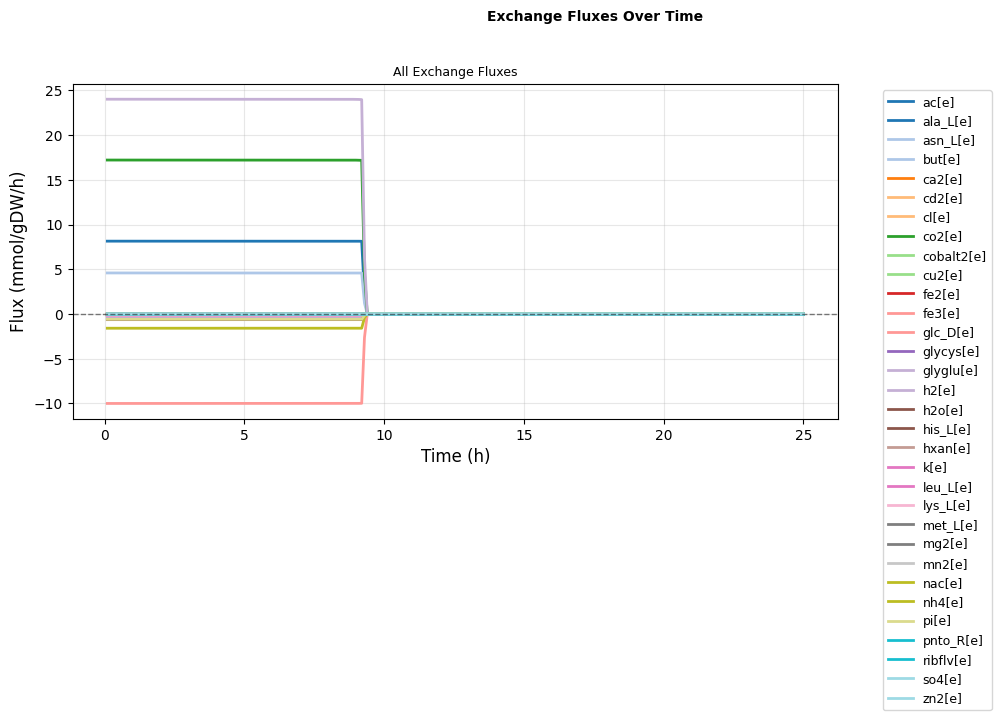

In [6]:
# Flux plot 
selected_flux_mets = [m for m in selected_mets if m != 'Biomass' and m in media_piv.columns]

fig3, ax = plt.subplots(figsize=(12, 6))

fig3.suptitle('Exchange Fluxes Over Time', fontsize=10, fontweight='bold', y=0.98)

time_flux = sim.fluxes.iloc[:, 0] * params.all_params['timeStep']

# different colors
colors = plt.cm.tab20(np.linspace(0, 1, len(selected_flux_mets)))

for i, met in enumerate(sorted(selected_flux_mets)):
    met_reaction_format = met.replace('[e]', '(e)')
    rxn_id = 'EX_' + met_reaction_format
     
    rxn_idx = comets_B.reactions[comets_B.reactions['REACTION_NAMES'] == rxn_id].index[0]
    col = 4 + rxn_idx
    flux = sim.fluxes.iloc[:, col]
    ax.plot(time_flux, flux, color=colors[i], linewidth=2, label=met)

ax.axhline(y=0, color='black', linestyle='--', linewidth=1, alpha=0.5)
ax.set_xlabel('Time (h)', fontsize=12)
ax.set_ylabel('Flux (mmol/gDW/h)', fontsize=12)
ax.set_title('All Exchange Fluxes', fontsize=9)
ax.grid(alpha=0.3)
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=9, ncol=1)

plt.tight_layout(rect=[0, 0, 0.85, 0.96])
plt.show()

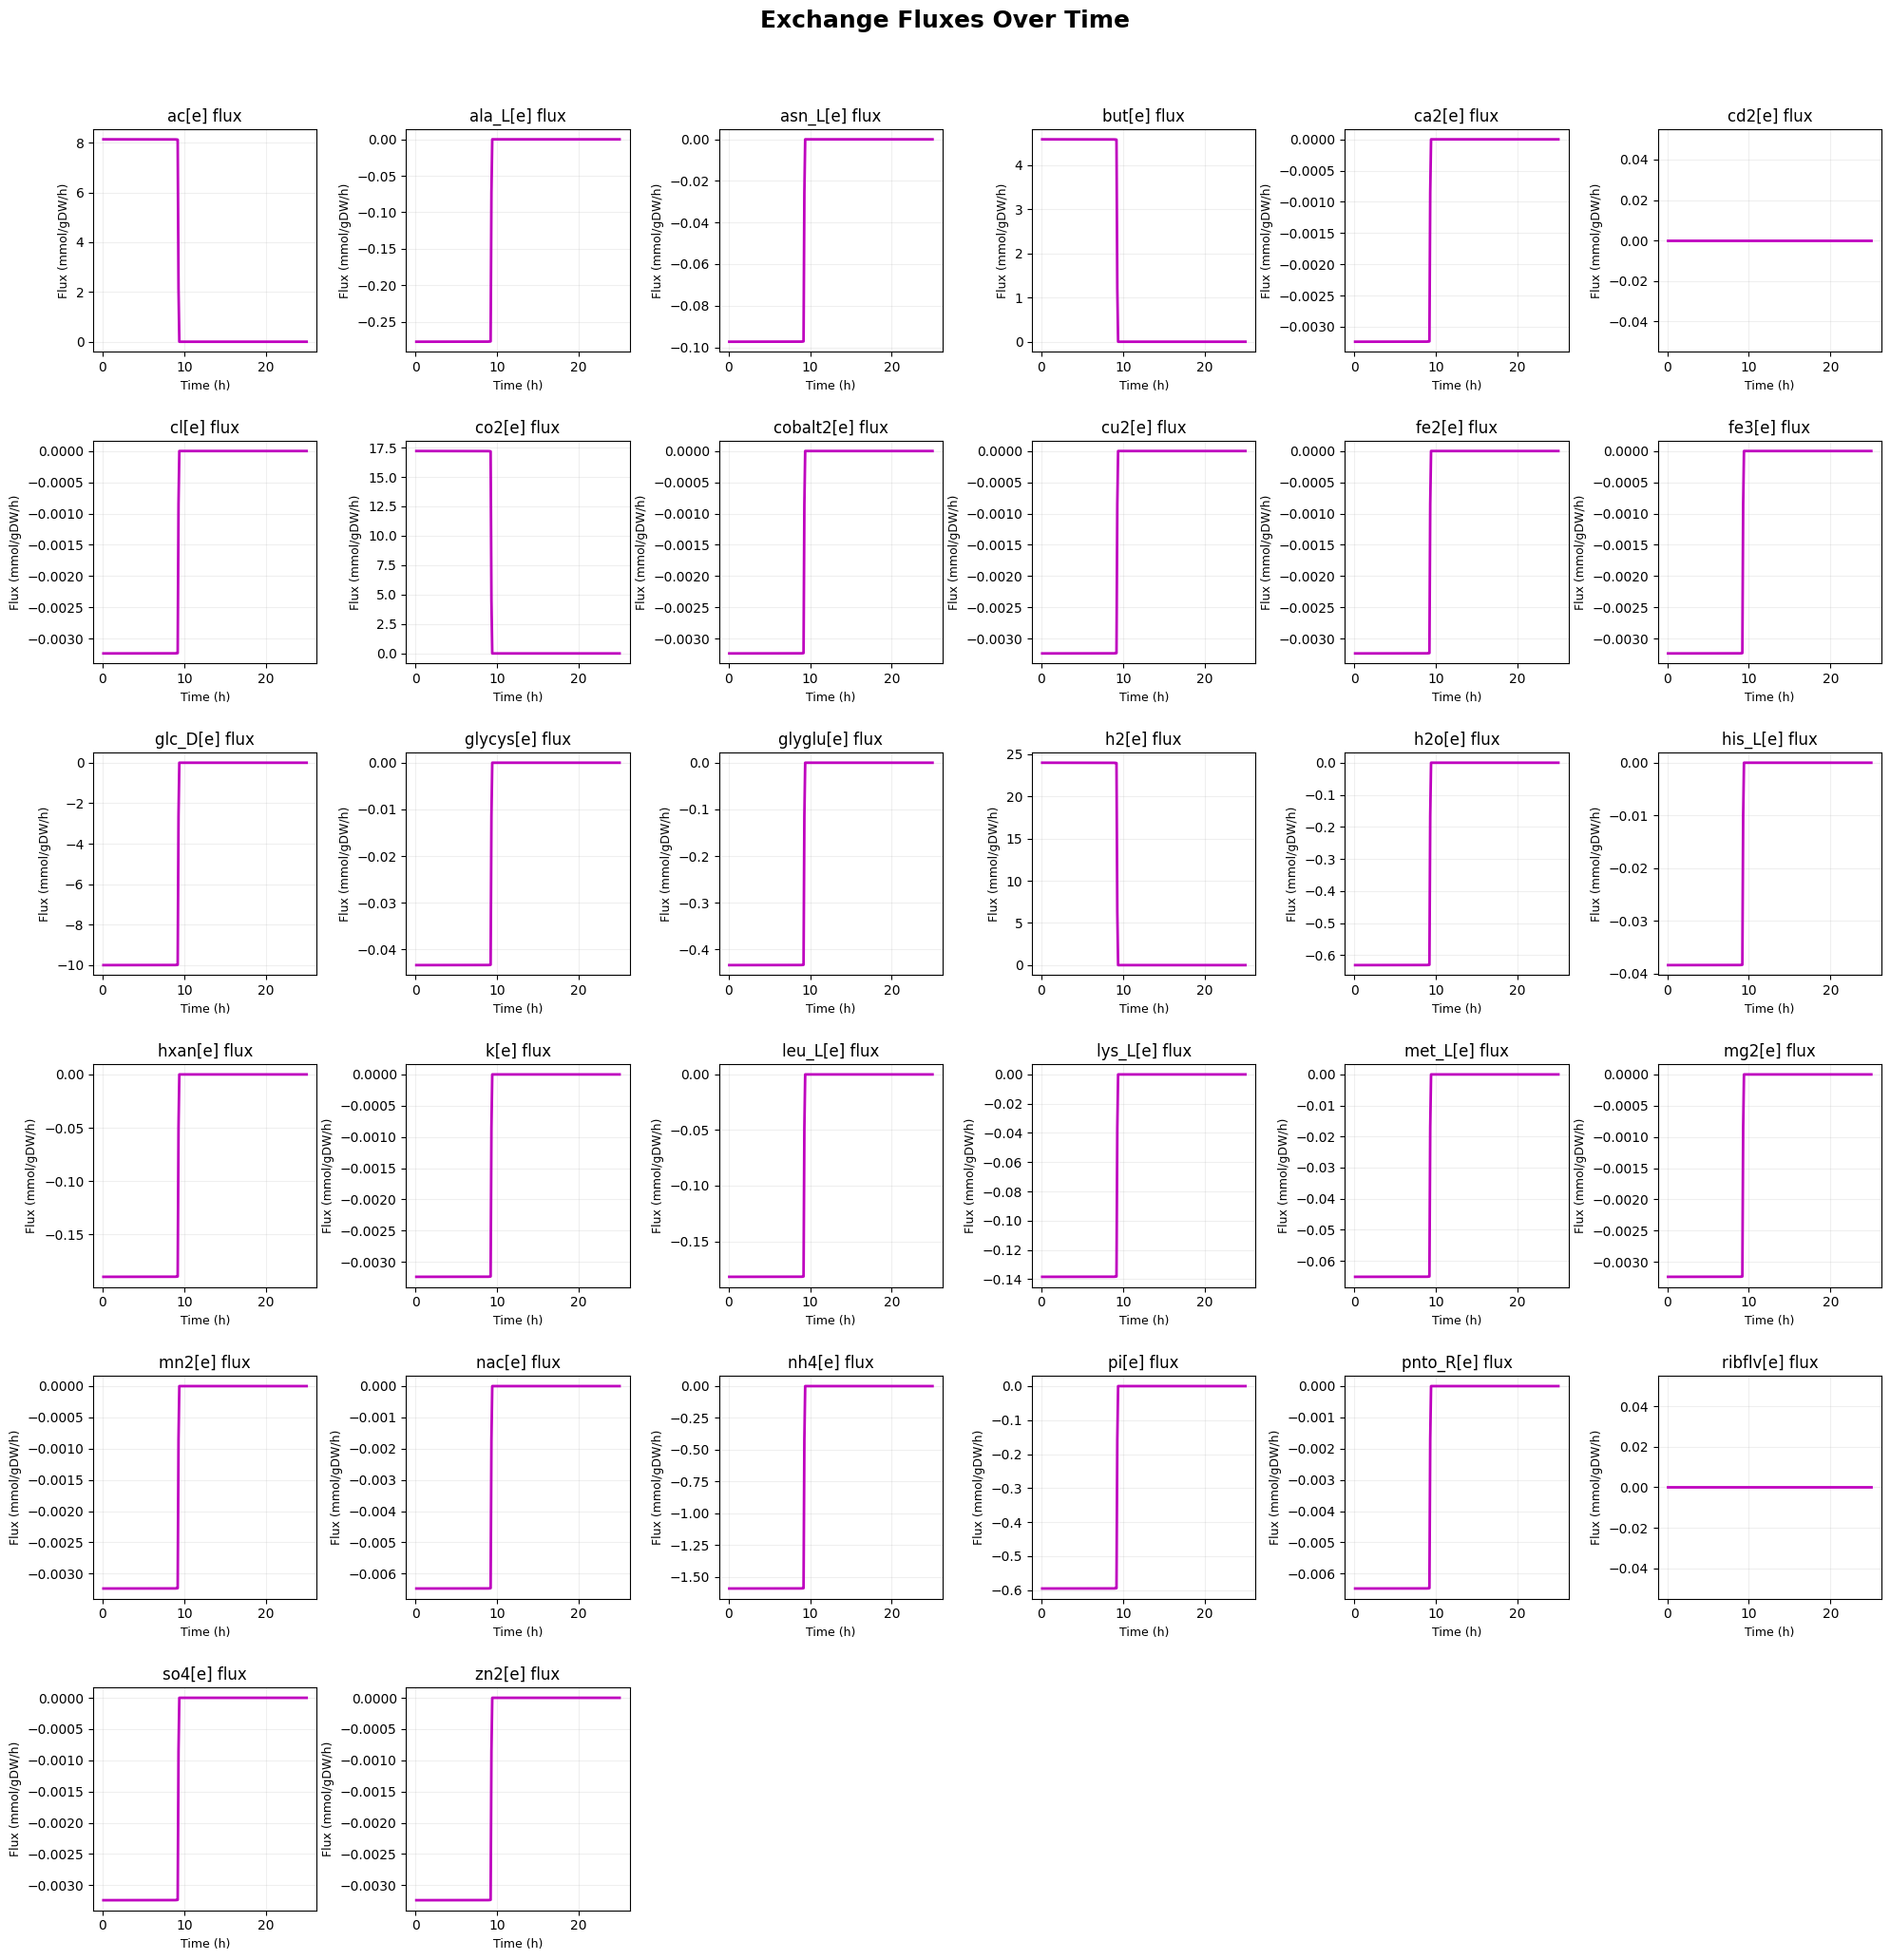

In [7]:
# Flux plot
#selected_flux_mets = [m for m in selected_mets if m != 'Biomass' and m in media_piv.columns]
num_flux = len(selected_flux_mets)
rows_flux = math.ceil(num_flux / cols)
fig3 = plt.figure(figsize=(20, 3.5 * rows_flux))

fig3.suptitle('Exchange Fluxes Over Time', fontsize=18, fontweight='bold', y=0.98)
#time_flux = sim.fluxes.iloc[:, 0] * params.all_params['timeStep']
for i, met in enumerate(sorted(selected_flux_mets)):
    met_reaction_format = met.replace('[e]', '(e)')
    rxn_id = 'EX_' + met_reaction_format
    
    rxn_idx = comets_B.reactions[comets_B.reactions['REACTION_NAMES'] == rxn_id].index[0]
    col = 4 + rxn_idx
    flux = sim.fluxes.iloc[:, col]
    ax = fig3.add_subplot(rows_flux, cols, i+1)
    ax.plot(time_flux, flux, color='m', linewidth=2)
    ax.set_title(met + ' flux', fontsize=12)
    ax.set_xlabel('Time (h)', fontsize=9)
    ax.set_ylabel('Flux (mmol/gDW/h)', fontsize=9)
    ax.grid(alpha=0.2)


plt.tight_layout(rect=[0, 0, 1, 0.96])
fig3.subplots_adjust(top=0.92, hspace=0.4, wspace=0.4)

plt.show()

Lets investigate the relationship between glucose and lactate consumption and butyrate production in Eubacterium.

In [1]:
 ### Simulation of Eubacterium with lactate
 
%reset -f

import os
# COMETS and Gurobi paths (macOS)
os.environ["GRB_LICENSE_FILE"] = "/gpfs1/sw/rh9/pkgs/gurobi/13.0.0/linux64/licenses/gurobi.lic"

In [2]:
import cobra as cb
import cometspy as c
import numpy as np 
import matplotlib.pyplot as plt  
import warnings
import math
warnings.filterwarnings('ignore', category=FutureWarning)

# Load model
model_1 = cb.io.load_matlab_model('Eubacterium_hallii_DSM_3353.mat')

# # Relax ATP maintenance reactions
# for rxn in model_1.reactions:
#     if rxn.id.upper().startswith("ATPM"):
#         rxn.lower_bound = 0.0

# Set default bounds for all exchanges: 
for rxn in model_1.exchanges:
    rxn.lower_bound = 0.0
    rxn.upper_bound = 1000.0

# Exchange list
all_exchanges_cobra = [rxn.id for rxn in model_1.exchanges]
print("Exchange reactions in model:", len(all_exchanges_cobra))

# External metabolite -> exchange reaction 
met_to_ex = {met.id: rxn.id for rxn in model_1.exchanges for met in rxn.metabolites if met.compartment == 'e'}
print("External metabolites with mapped exchanges:", len(met_to_ex))

# Medium
trace_metabolites = set([      
    'h2o[e]', 'pi[e]', 'fe2[e]', 'fe3[e]', 'zn2[e]', 'so4[e]', 'cu2[e]', 'k[e]', 'mg2[e]',
    'mn2[e]', 'cd2[e]', 'cl[e]', 'ca2[e]', 'cobalt2[e]', 'ribflv[e]',
    'pnto_R[e]', 'nac[e]', 'his_L[e]', 'asn_L[e]', 'glycys[e]', 'lys_L[e]', 'ala_L[e]',
    'met_L[e]',  'leu_L[e]', 'hxan[e]','glyglu[e]',
])

# Limited medium 
base_media = {
    "nh4[e]": 20.0,
    #"ser_L[e]": 10.0,
}

# Carbon sources 
glucose_only = {
    "glc_D[e]": 10.0,
}

glucose_lactate = {
    "glc_D[e]": 5.0,
    "lac_L[e]": 10.0,  
}

# Function to run simulation
def run_simulation(carbon_sources, condition_name):
    "Run COMETS simulation with specified carbon sources"
    
    # Combine medium
    lb_media = {**base_media, **carbon_sources}
    medium = list(trace_metabolites | set(lb_media.keys()))
    print(f"Condition: {condition_name}")
    print(f"Carbon sources: {list(carbon_sources.keys())}\n")
    
    model_copy = model_1.copy()
    model_copy.id = "Eubacterium"
    comets_model = c.model(model_copy)
    
    # Set objective 
    #comets_model.obj_style = "MAXIMIZE_OBJECTIVE_FLUX"

    comets_model.open_exchanges()
    
    # Initial population
    comets_model.initial_pop = [0, 0, 0.01]
    
    # Clean non-EX reactions from EXCH column
    ex_mask = comets_model.reactions["EXCH"].isin([True, "True"])
    exchanges_df = comets_model.reactions[ex_mask]
    for name in exchanges_df["REACTION_NAMES"]:
        name = str(name)
        if not name.startswith("EX_"):
            comets_model.reactions.loc[comets_model.reactions["REACTION_NAMES"] == name, "EXCH"] = False
            comets_model.reactions.loc[comets_model.reactions["REACTION_NAMES"] == name, "EXCH_IND"] = 0
    
    # Layout
    layout = c.layout([comets_model])
    layout.grid = [1, 1]
    
    # Track all external metabolites
    all_ex_mets = set(met_to_ex.keys())
    for met in all_ex_mets:
        layout.set_specific_metabolite(met, 0.0)
        layout.set_specific_refresh(met, 0.0)
    
    # Unlimited trace elements
    for met in trace_metabolites:
        layout.set_specific_metabolite(met, 1000.0)
        layout.set_specific_static(met, 1000)
    
    # Limited nutrients 
    for met in lb_media:
        if met in all_ex_mets:
            layout.set_specific_metabolite(met, lb_media[met])
            layout.set_specific_refresh(met, 0.0)
    
    # Parameters
    vol = 0.1
    params = c.params()
    params.set_param("spaceWidth", vol**(1/3))
    params.set_param("defaultVmax", 10.)
    params.set_param("defaultKm", 0.01)
    
    t_step = 0.1
    t_total = 250
    params.set_param("timeStep", t_step)
    params.set_param("maxSpaceBiomass", 10.)
    params.set_param("minSpaceBiomass", 1e-11)
    params.set_param("maxCycles", t_total)
    params.set_param("writeMediaLog", True)
    params.set_param("MediaLogRate", 1)
    params.set_param("writeFluxLog", True)
    params.set_param("FluxLogRate", 1)
    params.set_param("writeBiomassLog", True)
    params.set_param("BiomassLogRate", 1)
    params.set_param("exchangestyle", "Monod Style")
    
    sim = c.comets(layout, params)
    sim.run()
    
    return sim, condition_name

# Run both simulations
print("\nRUNNING SIMULATIONS\n")

sim_glc_only, name1 = run_simulation(glucose_only, "Glucose Only")
sim_glc_lac, name2 = run_simulation(glucose_lactate, "Glucose + Lactate")

No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e


Exchange reactions in model: 120
External metabolites with mapped exchanges: 119

RUNNING SIMULATIONS

Condition: Glucose Only
Carbon sources: ['glc_D[e]']


Running COMETS simulation ...
Done!
Condition: Glucose + Lactate
Carbon sources: ['glc_D[e]', 'lac_L[e]']


Running COMETS simulation ...
Done!


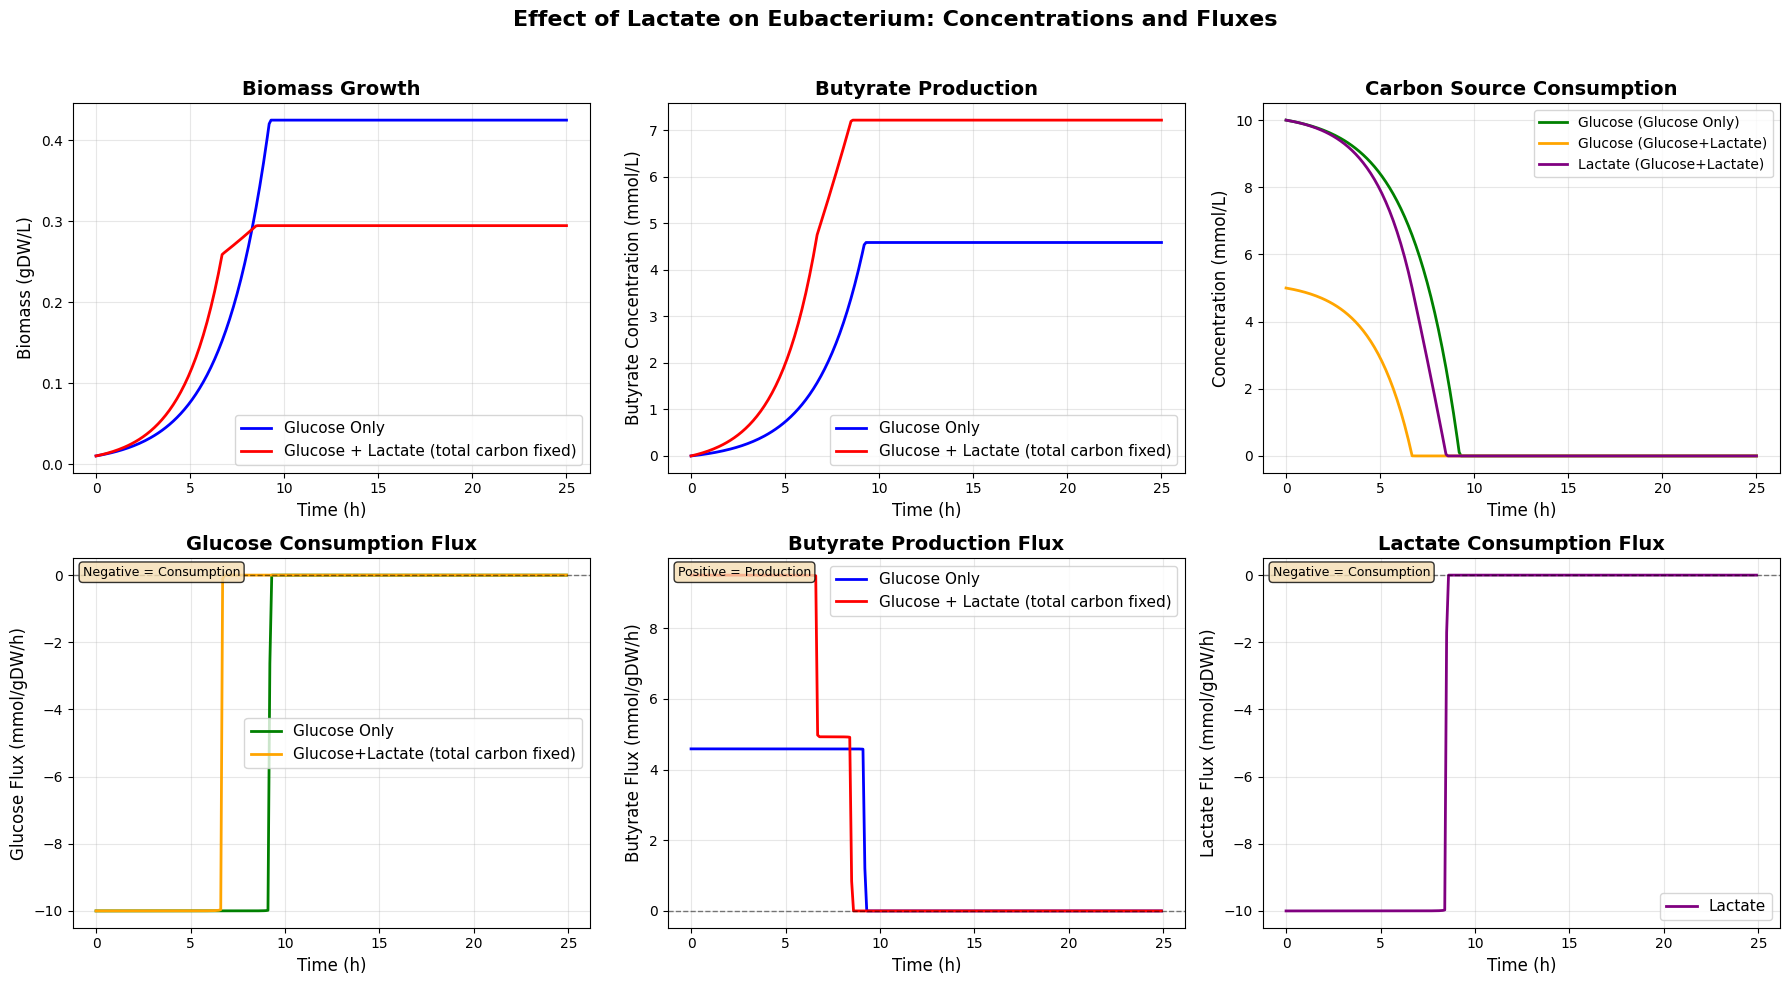

EFFECT OF LACTATE ON EUBACTERIUM

BIOMASS:
  Glucose Only: 0.424760 gDW/L
  Glucose + Lactate: 0.294436 gDW/L
  Enhancement: -30.7%

BUTYRATE:
  Glucose Only: 4.587 mmol/L
  Glucose + Lactate: 7.217 mmol/L
  Enhancement: +57.3%


In [3]:
# Simple data extraction
def get_met_data(sim, metabolite):
    media = sim.get_metabolite_time_series()
    if metabolite in media.columns:
        return media[metabolite].values

def get_flux_data(sim, metabolite, model_name="Eubacterium"):

    flux_df = sim.get_species_exchange_fluxes(model_name, threshold=1e-8)
    # Convert [e] to (e) for reaction naming
    met_reaction = metabolite.replace('[e]', '(e)')
    flux_col = 'EX_' + met_reaction
    
    if flux_col in flux_df.columns:
        return flux_df[flux_col].values
    else:
        return np.array([])


# Get time arrays
t_step = 0.1
time1 = np.arange(len(sim_glc_only.total_biomass)) * t_step
time2 = np.arange(len(sim_glc_lac.total_biomass)) * t_step

# Extract butyrate data
but_glc_only = get_met_data(sim_glc_only, 'but[e]')
but_glc_lac = get_met_data(sim_glc_lac, 'but[e]')

# Extract carbon source data
glc_only_glc = get_met_data(sim_glc_only, 'glc_D[e]')
glc_lac_glc = get_met_data(sim_glc_lac, 'glc_D[e]')
glc_lac_lac = get_met_data(sim_glc_lac, 'lac_L[e]')

# Extract biomass data
biomass_glc_only = sim_glc_only.total_biomass['Eubacterium'].values
biomass_glc_lac = sim_glc_lac.total_biomass['Eubacterium'].values

# Extract flux data
but_flux_glc_only = get_flux_data(sim_glc_only, 'but[e]')
but_flux_glc_lac = get_flux_data(sim_glc_lac, 'but[e]')
glc_flux_glc_only = get_flux_data(sim_glc_only, 'glc_D[e]')
glc_flux_glc_lac = get_flux_data(sim_glc_lac, 'glc_D[e]')
lac_flux_glc_lac = get_flux_data(sim_glc_lac, 'lac_L[e]')

# Get time arrays for fluxes  
if len(but_flux_glc_only) > 0:
    time1_flux = time1[:len(but_flux_glc_only)]
else:
    time1_flux = time1

if len(but_flux_glc_lac) > 0:
    time2_flux = time2[:len(but_flux_glc_lac)]
else:
    time2_flux = time2

# Create subplots: 2 rows, 3 columns
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle('Effect of Lactate on Eubacterium: Concentrations and Fluxes', 
             fontsize=16, fontweight='bold', y=0.98)

# Row 1: Concentrations
# Plot 1: Biomass growth comparison
ax = axes[0, 0]
ax.plot(time1, biomass_glc_only, 'b-', linewidth=2, label='Glucose Only')
ax.plot(time2, biomass_glc_lac, 'r-', linewidth=2, label='Glucose + Lactate (total carbon fixed)')
ax.set_xlabel('Time (h)', fontsize=12)
ax.set_ylabel('Biomass (gDW/L)', fontsize=12)
ax.set_title('Biomass Growth', fontsize=14, fontweight='bold')
ax.legend(fontsize=11)
ax.grid(alpha=0.3)

# Plot 2: Butyrate production comparison
ax = axes[0, 1]
ax.plot(time1, but_glc_only, 'b-', linewidth=2, label='Glucose Only')
ax.plot(time2, but_glc_lac, 'r-', linewidth=2, label='Glucose + Lactate (total carbon fixed)')
ax.set_xlabel('Time (h)', fontsize=12)
ax.set_ylabel('Butyrate Concentration (mmol/L)', fontsize=12)
ax.set_title('Butyrate Production', fontsize=14, fontweight='bold')
ax.legend(fontsize=11)
ax.grid(alpha=0.3)

# Plot 3: Carbon source consumption
ax = axes[0, 2]
ax.plot(time1, glc_only_glc, 'g-', linewidth=2, label='Glucose (Glucose Only)')
ax.plot(time2, glc_lac_glc, 'orange', linewidth=2, label='Glucose (Glucose+Lactate)')
ax.plot(time2, glc_lac_lac, 'purple', linewidth=2, label='Lactate (Glucose+Lactate)')
ax.set_xlabel('Time (h)', fontsize=12)
ax.set_ylabel('Concentration (mmol/L)', fontsize=12)
ax.set_title('Carbon Source Consumption', fontsize=14, fontweight='bold')
ax.legend(fontsize=10)
ax.grid(alpha=0.3)

# Row 2: Fluxes
# Plot 5: Glucose flux
ax = axes[1, 0]
if len(glc_flux_glc_only) > 0:
    ax.plot(time1_flux[:len(glc_flux_glc_only)], glc_flux_glc_only, 'g-', linewidth=2, label='Glucose Only')
if len(glc_flux_glc_lac) > 0:
    ax.plot(time2_flux[:len(glc_flux_glc_lac)], glc_flux_glc_lac, 'orange', linewidth=2, label='Glucose+Lactate (total carbon fixed)')
ax.axhline(y=0, color='k', linestyle='--', linewidth=1, alpha=0.5)
ax.set_xlabel('Time (h)', fontsize=12)
ax.set_ylabel('Glucose Flux (mmol/gDW/h)', fontsize=12)
ax.set_title('Glucose Consumption Flux', fontsize=14, fontweight='bold')
ax.legend(fontsize=11)
ax.grid(alpha=0.3)
ax.text(0.02, 0.98, 'Negative = Consumption', transform=ax.transAxes, 
        verticalalignment='top', fontsize=9,
        bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))

# Plot 4: Butyrate flux
ax = axes[1, 1]
if len(but_flux_glc_only) > 0:
    ax.plot(time1_flux, but_flux_glc_only, 'b-', linewidth=2, label='Glucose Only')
if len(but_flux_glc_lac) > 0:
    ax.plot(time2_flux, but_flux_glc_lac, 'r-', linewidth=2, label='Glucose + Lactate (total carbon fixed)')
ax.axhline(y=0, color='k', linestyle='--', linewidth=1, alpha=0.5)
ax.set_xlabel('Time (h)', fontsize=12)
ax.set_ylabel('Butyrate Flux (mmol/gDW/h)', fontsize=12)
ax.set_title('Butyrate Production Flux', fontsize=14, fontweight='bold')
ax.legend(fontsize=11)
ax.grid(alpha=0.3)
ax.text(0.02, 0.98, 'Positive = Production', transform=ax.transAxes, 
        verticalalignment='top', fontsize=9,
        bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))

# Plot 6: Lactate flux (only for glucose+lactate condition)
ax = axes[1, 2]
if len(lac_flux_glc_lac) > 0:
    ax.plot(time2_flux[:len(lac_flux_glc_lac)], lac_flux_glc_lac, 'purple', linewidth=2, label='Lactate')
ax.axhline(y=0, color='k', linestyle='--', linewidth=1, alpha=0.5)
ax.set_xlabel('Time (h)', fontsize=12)
ax.set_ylabel('Lactate Flux (mmol/gDW/h)', fontsize=12)
ax.set_title('Lactate Consumption Flux', fontsize=14, fontweight='bold')
ax.legend(fontsize=11)
ax.grid(alpha=0.3)
ax.text(0.02, 0.98, 'Negative = Consumption', transform=ax.transAxes, 
        verticalalignment='top', fontsize=9,
        bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

# Print summary
print("EFFECT OF LACTATE ON EUBACTERIUM\n")
print(f"BIOMASS:")
print(f"  Glucose Only: {biomass_glc_only[-1]:.6f} gDW/L")
print(f"  Glucose + Lactate: {biomass_glc_lac[-1]:.6f} gDW/L")
if biomass_glc_only[-1] > 0:
    biomass_enhancement = ((biomass_glc_lac[-1] - biomass_glc_only[-1]) / biomass_glc_only[-1]) * 100
    print(f"  Enhancement: {biomass_enhancement:+.1f}%")
print(f"\nBUTYRATE:")
print(f"  Glucose Only: {but_glc_only[-1]:.3f} mmol/L")
print(f"  Glucose + Lactate: {but_glc_lac[-1]:.3f} mmol/L")
if but_glc_only[-1] > 0:
    butyrate_enhancement = ((but_glc_lac[-1] - but_glc_only[-1]) / but_glc_only[-1]) * 100
    print(f"  Enhancement: {butyrate_enhancement:+.1f}%")


Trying to consider three different set of values for glucose anf lactate

In [1]:
 ### Simulation of Eubacterium with lactate

%reset -f

import os
# COMETS and Gurobi paths (macOS)
os.environ["GRB_LICENSE_FILE"] = "/gpfs1/sw/rh9/pkgs/gurobi/13.0.0/linux64/licenses/gurobi.lic"

No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e


Exchange reactions in model: 120
External metabolites with mapped exchanges: 119
Condition: Glucose Only
Carbon sources: ['glc_D[e]']

Running COMETS simulation ...
Done!
Condition: Glucose + Lactate (total carbon fixed)
Carbon sources: ['glc_D[e]', 'lac_L[e]']

Running COMETS simulation ...
Done!
Condition: Glucose + Lactate (individual substrates fixed)
Carbon sources: ['glc_D[e]', 'lac_L[e]']

Running COMETS simulation ...
Done!


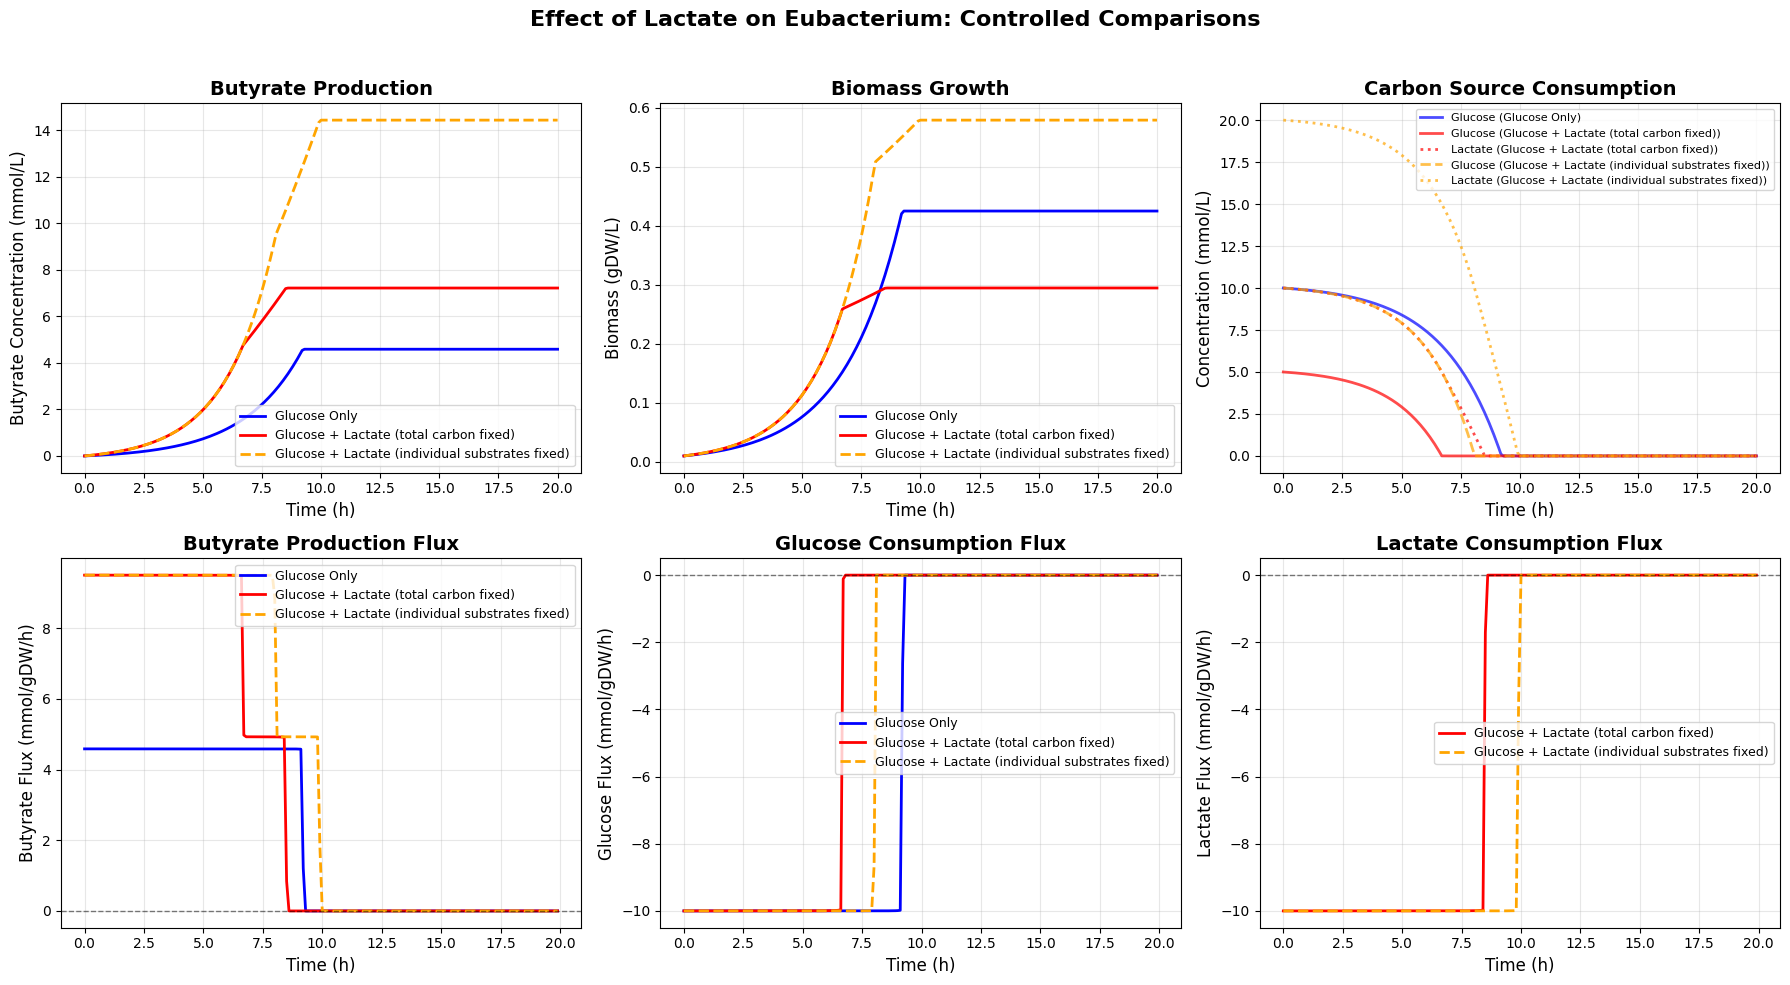

In [2]:
import cobra as cb
import cometspy as c
import numpy as np 
import matplotlib.pyplot as plt  
import warnings
import math
warnings.filterwarnings('ignore', category=FutureWarning)

# Load model
model_1 = cb.io.load_matlab_model('Eubacterium_hallii_DSM_3353.mat')

# # Relax ATP maintenance reactions
# for rxn in model_1.reactions:
#     if rxn.id.upper().startswith("ATPM"):
#         rxn.lower_bound = 0.0

# Set default bounds for all exchanges: 
for rxn in model_1.exchanges:
    rxn.lower_bound = 0.0
    rxn.upper_bound = 1000.0

# Exchange list
all_exchanges_cobra = [rxn.id for rxn in model_1.exchanges]
print("Exchange reactions in model:", len(all_exchanges_cobra))

# External metabolite -> exchange reaction 
met_to_ex = {met.id: rxn.id for rxn in model_1.exchanges for met in rxn.metabolites if met.compartment == 'e'}
print("External metabolites with mapped exchanges:", len(met_to_ex))

# Medium
trace_metabolites = set([      
    'h2o[e]', 'pi[e]', 'fe2[e]', 'fe3[e]', 'zn2[e]', 'so4[e]', 'cu2[e]', 'k[e]', 'mg2[e]',
    'mn2[e]', 'cd2[e]', 'cl[e]', 'ca2[e]', 'cobalt2[e]', 'ribflv[e]',
    'pnto_R[e]', 'nac[e]', 'his_L[e]', 'asn_L[e]', 'glycys[e]', 'lys_L[e]', 'ala_L[e]',
    'met_L[e]',  'leu_L[e]', 'hxan[e]','glyglu[e]',
])

# Limited medium 
base_media = {
    "nh4[e]": 20.0,
    #"ser_L[e]": 10.0,   
}

# conditions 
conditions = {
    "Glucose Only": {
        "glc_D[e]": 10.0,
    },
    "Glucose + Lactate (total carbon fixed)": {
        "glc_D[e]": 5.0,
        "lac_L[e]": 10.0,
    },
    "Glucose + Lactate (individual substrates fixed)": {
        "glc_D[e]": 10.0,
        "lac_L[e]": 20.0,
    },
}

# Function to run simulation
def run_simulation(carbon_sources, condition_name):
    
    # Combine medium
    lb_media = {**base_media, **carbon_sources}
    medium = list(trace_metabolites | set(lb_media.keys()))
    print(f"Condition: {condition_name}")
    print(f"Carbon sources: {list(carbon_sources.keys())}")
   
    model_copy = model_1.copy()
    model_copy.id = "Eubacterium"
    comets_model = c.model(model_copy)
    
    # Set objective 
    comets_model.obj_style = "MAXIMIZE_OBJECTIVE_FLUX" #"MAX_OBJECTIVE_MIN_TOTAL"

    comets_model.open_exchanges()
    
    # Initial population
    comets_model.initial_pop = [0, 0, 0.01]
    
    # Clean non-EX reactions from EXCH column
    ex_mask = comets_model.reactions["EXCH"].isin([True, "True"])
    exchanges_df = comets_model.reactions[ex_mask]
    for name in exchanges_df["REACTION_NAMES"]:
        name = str(name)
        if not name.startswith("EX_"):
            comets_model.reactions.loc[comets_model.reactions["REACTION_NAMES"] == name, "EXCH"] = False
            comets_model.reactions.loc[comets_model.reactions["REACTION_NAMES"] == name, "EXCH_IND"] = 0


    # mask = comets_model.reactions["REACTION_NAMES"] == "EX_lac_L(e)"
    # if mask.any():
    #     comets_model.reactions.loc[mask, "LB"] = 0.0
    
    # Layout
    layout = c.layout([comets_model])
    layout.grid = [1, 1]
    
    # Track all external metabolites
    all_ex_mets = set(met_to_ex.keys())
    for met in all_ex_mets:
        layout.set_specific_metabolite(met, 0.0)
        layout.set_specific_refresh(met, 0.0)
    
    # Unlimited trace elements
    for met in trace_metabolites & all_ex_mets:
        layout.set_specific_metabolite(met, 1000.0)
        layout.set_specific_static(met, 1000)
    
    # Limited nutrients 
    for met in lb_media:
        if met in all_ex_mets:
            layout.set_specific_metabolite(met, lb_media[met])
            layout.set_specific_refresh(met, 0.0)
    
    # Parameters
    vol = 0.1
    params = c.params()
    params.set_param("spaceWidth", vol**(1/3))
    params.set_param("defaultVmax", 10.)
    params.set_param("defaultKm", 0.01)
    
    t_step = 0.1
    t_total = 200
    params.set_param("timeStep", t_step)
    params.set_param("maxSpaceBiomass", 10.)
    params.set_param("minSpaceBiomass", 1e-11)
    params.set_param("maxCycles", t_total)
    params.set_param("writeMediaLog", True)
    params.set_param("MediaLogRate", 1)
    params.set_param("writeFluxLog", True)
    params.set_param("FluxLogRate", 1)
    params.set_param("writeBiomassLog", True)
    params.set_param("BiomassLogRate", 1)
    params.set_param("exchangestyle", "Monod Style")
    
    sim = c.comets(layout, params)
    sim.run()
    
    return sim, condition_name

# Run simulations
simulations = {}
for condition_name, carbon_sources in conditions.items():
    sim, name = run_simulation(carbon_sources, condition_name)
    simulations[condition_name] = sim

# Extract data 
def get_met_data(sim, metabolite):
    media = sim.get_metabolite_time_series()
    if metabolite in media.columns:
        return media[metabolite].values


def get_flux_data(sim, metabolite, model_name="Eubacterium"):

    flux_df = sim.get_species_exchange_fluxes(model_name, threshold=1e-8)
    met_reaction = metabolite.replace('[e]', '(e)')
    flux_col = 'EX_' + met_reaction
    
    if flux_col in flux_df.columns:
        return flux_df[flux_col].values
    else:
        return np.array([])


# Extract data for all conditions
t_step = 0.1
data = {}
colors = ['blue', 'red', 'orange']  
linestyles = ['-', '-', '--']  

for i, (condition_name, sim) in enumerate(simulations.items()):
    time = np.arange(len(sim.total_biomass)) * t_step
    data[condition_name] = {
        'time': time,
        'butyrate': get_met_data(sim, 'but[e]'),
        'biomass': sim.total_biomass['Eubacterium'].values,
        'glucose': get_met_data(sim, 'glc_D[e]'),
        'lactate': get_met_data(sim, 'lac_L[e]'),
        'but_flux': get_flux_data(sim, 'but[e]'),
        'glc_flux': get_flux_data(sim, 'glc_D[e]'),
        'lac_flux': get_flux_data(sim, 'lac_L[e]'),
        'color': colors[i],
        'linestyle': linestyles[i]
    }

# comparison plots
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle('Effect of Lactate on Eubacterium: Controlled Comparisons', 
             fontsize=16, fontweight='bold', y=0.98)

# Row 1: Concentrations
# Plot 1: Butyrate production
ax = axes[0, 0]
for condition_name, d in data.items():
    ax.plot(d['time'], d['butyrate'], color=d['color'], linestyle=d['linestyle'], 
            linewidth=2, label=condition_name)
ax.set_xlabel('Time (h)', fontsize=12)
ax.set_ylabel('Butyrate Concentration (mmol/L)', fontsize=12)
ax.set_title('Butyrate Production', fontsize=14, fontweight='bold')
ax.legend(fontsize=9)
ax.grid(alpha=0.3)

# Plot 2: Biomass growth
ax = axes[0, 1]
for condition_name, d in data.items():
    ax.plot(d['time'], d['biomass'], color=d['color'], linestyle=d['linestyle'], 
            linewidth=2, label=condition_name)
ax.set_xlabel('Time (h)', fontsize=12)
ax.set_ylabel('Biomass (gDW/L)', fontsize=12)
ax.set_title('Biomass Growth', fontsize=14, fontweight='bold')
ax.legend(fontsize=9)
ax.grid(alpha=0.3)

# Plot 3: Carbon source consumption
ax = axes[0, 2]
for condition_name, d in data.items():
    ax.plot(d['time'], d['glucose'], color=d['color'], linestyle=d['linestyle'], 
            linewidth=2, label=f'Glucose ({condition_name})', alpha=0.7)
    if 'Lactate' in condition_name:
        ax.plot(d['time'], d['lactate'], color=d['color'], linestyle=':', 
                linewidth=2, label=f'Lactate ({condition_name})', alpha=0.7)
ax.set_xlabel('Time (h)', fontsize=12)
ax.set_ylabel('Concentration (mmol/L)', fontsize=12)
ax.set_title('Carbon Source Consumption', fontsize=14, fontweight='bold')
ax.legend(fontsize=8, ncol=1)
ax.grid(alpha=0.3)

# Row 2: Fluxes
# Plot 4: Butyrate flux
ax = axes[1, 0]
for condition_name, d in data.items():
    if len(d['but_flux']) > 0:
        time_flux = d['time'][:len(d['but_flux'])]
        ax.plot(time_flux, d['but_flux'], color=d['color'], linestyle=d['linestyle'], 
                linewidth=2, label=condition_name)
ax.axhline(y=0, color='k', linestyle='--', linewidth=1, alpha=0.5)
ax.set_xlabel('Time (h)', fontsize=12)
ax.set_ylabel('Butyrate Flux (mmol/gDW/h)', fontsize=12)
ax.set_title('Butyrate Production Flux', fontsize=14, fontweight='bold')
ax.legend(fontsize=9)
ax.grid(alpha=0.3)

# Plot 5: Glucose flux
ax = axes[1, 1]
for condition_name, d in data.items():
    if len(d['glc_flux']) > 0:
        time_flux = d['time'][:len(d['glc_flux'])]
        ax.plot(time_flux, d['glc_flux'], color=d['color'], linestyle=d['linestyle'], 
                linewidth=2, label=condition_name)
ax.axhline(y=0, color='k', linestyle='--', linewidth=1, alpha=0.5)
ax.set_xlabel('Time (h)', fontsize=12)
ax.set_ylabel('Glucose Flux (mmol/gDW/h)', fontsize=12)
ax.set_title('Glucose Consumption Flux', fontsize=14, fontweight='bold')
ax.legend(fontsize=9)
ax.grid(alpha=0.3)

# Plot 6: Lactate flux 
ax = axes[1, 2]
for condition_name, d in data.items():
    if 'Lactate' in condition_name and len(d['lac_flux']) > 0:
        time_flux = d['time'][:len(d['lac_flux'])]
        ax.plot(time_flux, d['lac_flux'], color=d['color'], linestyle=d['linestyle'], 
                linewidth=2, label=condition_name)
ax.axhline(y=0, color='k', linestyle='--', linewidth=1, alpha=0.5)
ax.set_xlabel('Time (h)', fontsize=12)
ax.set_ylabel('Lactate Flux (mmol/gDW/h)', fontsize=12)
ax.set_title('Lactate Consumption Flux', fontsize=14, fontweight='bold')
ax.legend(fontsize=9)
ax.grid(alpha=0.3)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

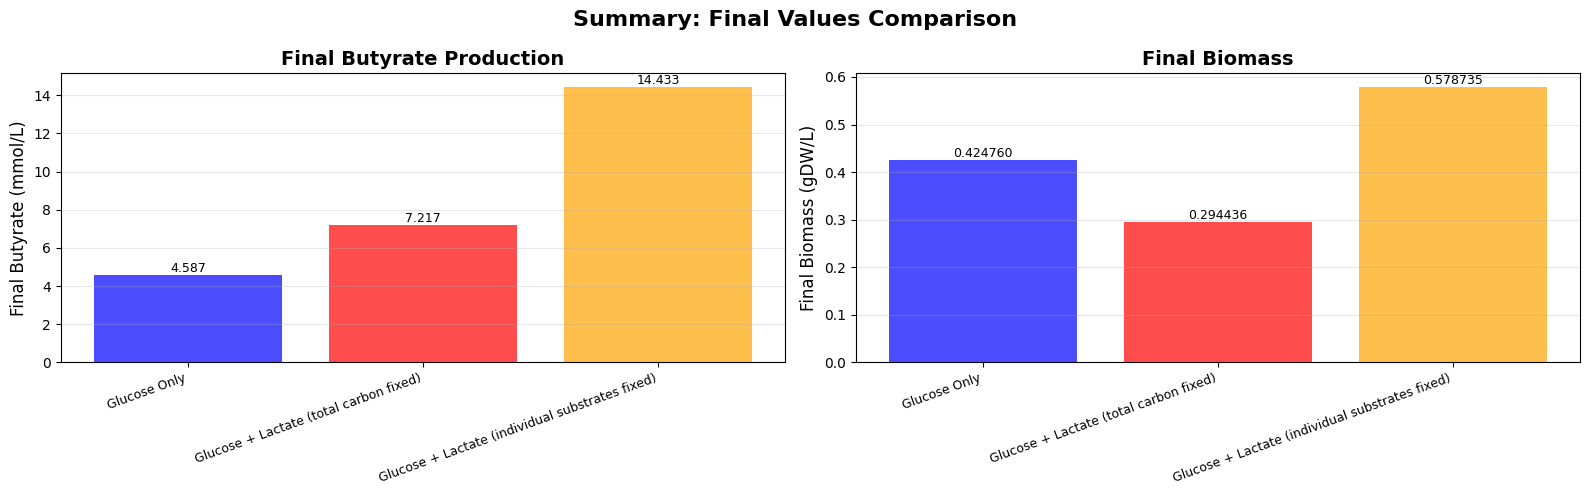


SUMMARY: ALL CONDITIONS COMPARISON

Condition                                          Final Biomass (gDW/L)     Final Butyrate (mmol/L)  
Glucose Only                                       0.424760                  4.587                    
Glucose + Lactate (total carbon fixed)             0.294436                  7.217                    
Glucose + Lactate (individual substrates fixed)    0.578735                  14.433                   

 Enchancement relative to glucose only

Condition                                          Biomass Enhancement (%)   Butyrate Enhancement (%) 
Glucose + Lactate (total carbon fixed)             -30.7                     57.3                     
Glucose + Lactate (individual substrates fixed)    36.3                      214.7                    


In [3]:
# Summary comparison plot
fig2, axes2 = plt.subplots(1, 2, figsize=(16, 5)) 
fig2.suptitle('Summary: Final Values Comparison', fontsize=16, fontweight='bold')

# Final butyrate comparison
ax = axes2[0]
condition_names = list(data.keys())
final_butyrate = [d['butyrate'][-1] for d in data.values()]
colors_list = [d['color'] for d in data.values()]

bars = ax.bar(range(len(condition_names)), final_butyrate, color=colors_list, alpha=0.7)
ax.set_ylabel('Final Butyrate (mmol/L)', fontsize=12)
ax.set_title('Final Butyrate Production', fontsize=14, fontweight='bold')
ax.set_xticks(range(len(condition_names)))
ax.set_xticklabels(condition_names, rotation=20, ha='right', fontsize=9)
ax.grid(alpha=0.3, axis='y')

# Add value labels on bars
for bar, val in zip(bars, final_butyrate):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{val:.3f}', ha='center', va='bottom', fontsize=9)

# Final biomass comparison
ax = axes2[1]
final_biomass = [d['biomass'][-1] for d in data.values()]

bars = ax.bar(range(len(condition_names)), final_biomass, color=colors_list, alpha=0.7)
ax.set_ylabel('Final Biomass (gDW/L)', fontsize=12)
ax.set_title('Final Biomass', fontsize=14, fontweight='bold')
ax.set_xticks(range(len(condition_names)))
ax.set_xticklabels(condition_names, rotation=20, ha='right', fontsize=9)
ax.grid(alpha=0.3, axis='y')

# Add value labels on bars
for bar, val in zip(bars, final_biomass):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{val:.6f}', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

# Print summary table
print("\nSUMMARY: ALL CONDITIONS COMPARISON\n")
print(f"{'Condition':<50} {'Final Biomass (gDW/L)':<25} {'Final Butyrate (mmol/L)':<25}")

for condition_name, d in data.items():
    print(f"{condition_name:<50} {d['biomass'][-1]:<25.6f} {d['butyrate'][-1]:<25.3f}")

# Enhancements relative to glucose only
glc_only_biomass = data['Glucose Only']['biomass'][-1]
glc_only_butyrate = data['Glucose Only']['butyrate'][-1]

print("\n Enchancement relative to glucose only\n")
print(f"{'Condition':<50} {'Biomass Enhancement (%)':<25} {'Butyrate Enhancement (%)':<25}")


for condition_name, d in data.items():
    if condition_name != 'Glucose Only':
        biomass_enh = ((d['biomass'][-1] - glc_only_biomass) / glc_only_biomass) * 100 if glc_only_biomass > 0 else 0
        butyrate_enh = ((d['butyrate'][-1] - glc_only_butyrate) / glc_only_butyrate) * 100 if glc_only_butyrate > 0 else 0
        print(f"{condition_name:<50} {biomass_enh:<25.1f} {butyrate_enh:<25.1f}")